# ⭐ Initial Run

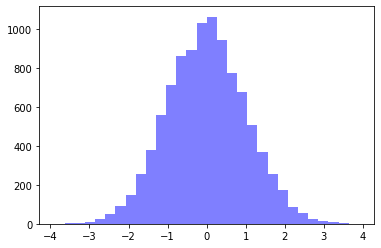

In [3]:
# INITIAL RUN - On Kernal Restart, run until graph shows
import warnings   # silence numpy warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np

x = np.random.randn(10_000)
plt.hist(x, bins=30, facecolor="blue", alpha=0.5)
plt.show()

In [3]:
!ls -lh wd-triples-P31-obj-set*

-rw-r--r-- 1 nc nc  13M Aug 23 20:32 wd-triples-P31-obj-set-sports-football-club-team-labeled.tsv
-rw-r--r-- 1 nc nc 3.8M Aug 23 20:32 wd-triples-P31-obj-set-sports-football-club-team.tsv
-rw-r--r-- 1 nc nc  70M Aug 17 16:02 wd-triples-P31-obj-set-sports-season-sporting-event-labeled.tsv
-rw-r--r-- 1 nc nc  20M Aug 11 19:33 wd-triples-P31-obj-set-sports-season-sporting-event.tsv


# Pre-processing

- Use triples output TSV files as input for embeddings


# Embedding Algorithms

- https://github.com/Accenture/AmpliGraph
    - " TransE [BUGD+13] relies on distances, DistMult [YYH+14] and ComplEx [TWR+16] are bilinear-diagonal models, HolE [NRP+16] uses circular correlation. While the above models can be interpreted as multilayer perceptrons, others such as ConvE include convolutional layers [DMSR18]."

-  https://kge-tutorial-ecai2020.github.io/ECAI-20_KGE_tutorial.pdf

Others:
- https://github.com/facebookresearch/PyTorch-BigGraph
- https://github.com/awslabs/dgl-ke
- https://towardsdatascience.com/introduction-to-knowledge-graph-embedding-with-dgl-ke-77ace6fb60ef







In [5]:
# ampligraph.__version__

# ConvE

## Testing GoT

In [13]:
# TEST GoT - 
"""
Train set size:  (3075, 3)
Test set size:  (100, 3)
MRR: 0.12
Hits@50: 0.40
Hits@10: 0.24
Hits@3: 0.14
Hits@1: 0.06

"""
import numpy as np
# import warnings   # silence numpy warnings
# warnings.filterwarnings('ignore')
import pandas as pd
import ampligraph
from ampligraph.datasets import load_from_csv
from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.latent_features import ComplEx, ConvE, TransE
from ampligraph.latent_features import save_model, restore_model
from ampligraph.evaluation import evaluate_performance, mr_score, mrr_score, hits_at_n_score
from ampligraph.utils import create_tensorboard_visualizations
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

X = load_from_csv('.', 'GoT.csv', sep=',')
entities = np.unique(np.concatenate([X[:, 0], X[:, 2]]))
relations = np.unique(X[:, 1])

X_train, X_test = train_test_split_no_unseen(X, test_size=100) 
print('Train set size: ', X_train.shape)
print('Test set size: ', X_test.shape)

model = ConvE(k=100,
              eta=2,
              epochs=100, 
              batches_count=20, 
              seed=0, 
              embedding_model_params={'conv_filters': 32,
                                      'conv_kernel_size': 3, 
                                      'dropout_conv': 0.3, 
                                      'dropout_dense': 0.2, 
                                      'dropout_embed': 0.2, 
                                      'use_batchnorm': True, 
                                      'use_bias': True}, 
              optimizer='adam', 
              optimizer_params={'lr': 0.0005}, 
              loss='bce', 
#               loss_params={'label_smoothing': 0.1, 
#                            'label_weighting': False},
              regularizer=None, 
              regularizer_params={}, 
              initializer='xavier', 
              initializer_params={'uniform': False}, 
              low_memory=False, 
              verbose=False)
# model = ConvE()

positives_filter = X
model.fit(X_train, early_stopping=False)

ranks = evaluate_performance(X_test, 
                             model=model, 
                             filter_triples=positives_filter,   # Corruption strategy filter defined above 
                             use_default_protocol=True, # corrupt subj and obj separately while evaluating
                             verbose=True)
mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))
hits_50 = hits_at_n_score(ranks, n=50)
print("Hits@50: %.2f" % (hits_50))
hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

Train set size:  (3075, 3)
Test set size:  (100, 3)
WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.
Mapping set data: test
Mapping set data: filter
MRR: 0.12
Hits@50: 0.40
Hits@10: 0.24
Hits@3: 0.14
Hits@1: 0.06


## Testing on `wd-triples-P31-obj-set-bio-taxon-gene`

In [ ]:
# TEST 
"""
'wd-triples-P31-obj-set-bio-taxon-gene-labeled-1M.tsv' - not enough memory

"""
import numpy as np
import warnings   # silence numpy warnings
warnings.filterwarnings('ignore')
import pandas as pd
import ampligraph
from ampligraph.datasets import load_from_csv
from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.latent_features import ComplEx, ConvE, TransE
from ampligraph.latent_features import save_model, restore_model
from ampligraph.evaluation import evaluate_performance, mr_score, mrr_score, hits_at_n_score
from ampligraph.utils import create_tensorboard_visualizations
import random
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)


variant = 'ConvE-bio-taxon-gene'

# data = 'wd-triples-P31-obj-set-bio-taxon-gene-labeled-10K.tsv'
data = 'wd-triples-P31-obj-set-bio-taxon-gene-labeled-100K.tsv'
# data = 'wd-triples-P31-obj-set-bio-taxon-gene-labeled-1M.tsv'

# Load data
print(data)
X = load_from_csv('', data, sep='\t', header=1)
entities = np.unique(np.concatenate([X[:, 0], X[:, 2]]))
relations = np.unique(X[:, 1])

# Training/test split
num_test = int(len(X) * 0.05)  # Test size affects time to complete
data = {}
data['train'], data['test'] = train_test_split_no_unseen(X, test_size=num_test, seed=0, allow_duplication=False)
print("Set sizes: Train:", len(data['train']), ", Test:", len(data['test']) )
# data['train'], data['valid'] = train_test_split_no_unseen(data['train'], test_size=num_test)
# print("Set sizes: Train:", len(data['train']), ", Test:", len(data['test']), ", Validation:", len(data['valid']) )

#### Model hyperparameters
model = ConvE(k=100,
              eta=2,
              epochs=100, 
              batches_count=20, 
              seed=0, 
              embedding_model_params={'conv_filters': 32,
                                      'conv_kernel_size': 3, 
                                      'dropout_conv': 0.3, 
                                      'dropout_dense': 0.2, 
                                      'dropout_embed': 0.2, 
                                      'use_batchnorm': True, 
                                      'use_bias': True}, 
              optimizer='adam', 
              optimizer_params={'lr': 0.0005}, 
              loss='bce', 
#               loss_params={'label_smoothing': 0.1, 
#                            'label_weighting': False},
              regularizer=None, 
              regularizer_params={}, 
              initializer='xavier', 
              initializer_params={'uniform': False}, 
              low_memory=True, 
              verbose=False)

# model = restore_model('model-ConvE-bio-taxon-gene.pkl')

# Checking that negative statements are in fact negative
positives_filter = X # data['train'] + data['test'] + data['valid']
filter1 = np.concatenate((data['train'], data['test'], data['valid'] )) if data.get('valid') else np.concatenate((data['train'], data['test'] ))

#### Train - no early stopping
model.fit(data['train'], early_stopping=False)

#### Train
# tf.logging.set_verbosity(tf.logging.ERROR)
# model.fit(data['train'],
#           early_stopping=True,
#           early_stopping_params = \
#                       {
#                           'x_valid': data['valid'],       # validation set
#                           'criteria':'hits10',         # Uses hits10 criteria for early stopping
#                           'burn_in':1,              # early stopping kicks in after 100 epochs
#                           'check_interval':5,         # validates every 20th epoch
#                           'stop_interval':5,           # stops if 5 successive validation checks are bad.
#                           'x_filter': filter1,          # Use filter for filtering out positives 
#                           'corruption_entities':[1,2,3], # 'all' = corrupt using all entities
#                                                 # all, entities[:int(len(entities) * 0.05)] , 
#                           'corrupt_side':'s+o'         # corrupt subject and object (but not at once)
#                       })

# Saving model
save_model(model, './model-'+ variant +'.pkl')

# Tensorboard model
# create_tensorboard_visualizations(model, 'tensorboard_files-' + variant)

#### Evaluate
ranks = evaluate_performance(data['test'], 
                             model=model,
                             filter_unseen=True,  # could be False since train_test_split_unseen() used
                             entities_subset=random.sample(list(entities), 30), #entities[:100],
                             filter_triples=filter1, # Corruption strategy filter defined above 
                             #use_default_protocol=True, # default: False, If True, corrupt_side is ‘s,o’
                             corrupt_side='s',  #'s+o' NOT in ConvE, # Replaces use_default_protocol
                             verbose=True)
print('Ranks calculated')
mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))
hits_50 = hits_at_n_score(ranks, n=50)
print("Hits@50: %.2f" % (hits_50))
hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

wd-triples-P31-obj-set-bio-taxon-gene-labeled-100K.tsv
Set sizes: Train: 94989 , Test: 4999
Mapping set data: test
Mapping set data: filter


# ComplEx #

## Testing GoT, wn18 ##

In [9]:
# TEST GoT - worked OK
"""
Average Loss:   0.017603: 100%|██████████| 200/200 [02:42<00:00,  1.23epoch/s]
100%|██████████| 100/100 [00:00<00:00, 124.07it/s]
MRR: 0.41
Hits@50: 0.70
Hits@10: 0.55
Hits@3: 0.45
Hits@1: 0.34
"""
import numpy as np
import pandas as pd
import ampligraph

X = load_from_csv('.', 'GoT.csv', sep=',')
entities = np.unique(np.concatenate([X[:, 0], X[:, 2]]))
relations = np.unique(X[:, 1])

from ampligraph.evaluation import train_test_split_no_unseen 

X_train, X_test = train_test_split_no_unseen(X, test_size=100) 
print('Train set size: ', X_train.shape)
print('Test set size: ', X_test.shape)

from ampligraph.latent_features import ComplEx
model = ComplEx(batches_count=100, 
                seed=0, 
                epochs=200, 
                k=150, 
                eta=5,
                optimizer='adam', 
                optimizer_params={'lr':1e-3},
                loss='multiclass_nll', 
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                verbose=True)

positives_filter = X

model.fit(X_train, early_stopping = False)

from ampligraph.evaluation import evaluate_performance
ranks = evaluate_performance(X_test, 
                             model=model, 
                             filter_triples=positives_filter,   # Corruption strategy filter defined above 
                             use_default_protocol=True, # corrupt subj and obj separately while evaluating
                             verbose=True)

from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))

hits_50 = hits_at_n_score(ranks, n=50)
print("Hits@50: %.2f" % (hits_50))
hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

Train set size:  (3075, 3)
Test set size:  (100, 3)


Average Loss:   0.017603: 100%|██████████| 200/200 [02:42<00:00,  1.23epoch/s]

WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.



100%|██████████| 100/100 [00:00<00:00, 124.07it/s]


MRR: 0.41
Hits@50: 0.70
Hits@10: 0.55
Hits@3: 0.45
Hits@1: 0.34


In [10]:
# TEST wn18 - worked OK
""" Using model.fit(data['train'], early_stopping=False)
Average Loss:   0.003341: 100%|██████████| 200/200 [1:14:40<00:00, 22.40s/epoch]
100%|██████████| 5000/5000 [13:28<00:00,  6.18it/s]
MRR: 0.85
Hits@50: 0.96
Hits@10: 0.93
Hits@3: 0.89
Hits@1: 0.79

Average Loss:   0.003341 — Best validation (hits10): 0.940200: 100%|██████████| 200/200 [2:34:59<00:00, 46.50s/epoch]   
100%|██████████| 5000/5000 [13:27<00:00,  6.19it/s]
MRR: 0.85
Hits@50: 0.96
Hits@10: 0.93
Hits@3: 0.89
Hits@1: 0.79
"""
import numpy as np
import warnings   # silence numpy warnings
warnings.filterwarnings('ignore')
import pandas as pd
import ampligraph
from ampligraph.datasets import load_from_csv
from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.latent_features import ComplEx, ConvE, TransE
from ampligraph.latent_features import save_model, restore_model
from ampligraph.evaluation import evaluate_performance, mr_score, mrr_score, hits_at_n_score
from ampligraph.utils import create_tensorboard_visualizations
import tensorflow as tf

from ampligraph.datasets import load_wn18
X = load_wn18()
# data = {'train': X['train'][:800], 'test': X['test'][:100], 'valid': X['valid'][:100] }
data = {'train': X['train'], 'test': X['test'], 'valid': X['valid'] }

#### Model hyperparameters
model = ComplEx(batches_count=100, 
                seed=0, 
                epochs=200,
                k=150, 
                eta=5,
                optimizer='adam', # adam, sdg
                optimizer_params={'lr':1e-3},
                loss='multiclass_nll', 
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                verbose=True)

# Checking that negative statements are in fact negative
positives_filter = X['train']

#### Train
# model.fit(data['train'], early_stopping=False)

tf.logging.set_verbosity(tf.logging.ERROR)
filter1 = np.concatenate((data['train'], data['valid'], data['test']))
model.fit(data['train'],
          early_stopping=True,
          early_stopping_params = \
                      {
                          'x_valid': data['valid'],       
                          'criteria':'hits10',         
                          'burn_in': 100,              
                          'check_interval':20,         
                          'stop_interval':5,           
                          'x_filter': filter1,          
                          'corruption_entities': 'all', #[1,2,3,4,5], #'all', #entities[:int(len(entities) * 0.05)] , 
                          'corrupt_side':'s+o'         
                      })

#### Evaluate
ranks = evaluate_performance(data['test'], 
                             model=model,
                             filter_unseen=True,
                             filter_triples=positives_filter, # Corruption strategy filter defined above 
                             use_default_protocol=True, # corrupt subj and obj separately while evaluating
                             #corrupt_side='s+o', # Replaces use_default_protocol
                             verbose=True)

mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))

hits_50 = hits_at_n_score(ranks, n=50)
print("Hits@50: %.2f" % (hits_50))
hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

# Tensorflow
# create_tensorboard_visualizations(model, 'embeddings-' + variant)

Average Loss:   0.003341 — Best validation (hits10): 0.940200: 100%|██████████| 200/200 [2:34:59<00:00, 46.50s/epoch]   


WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████| 5000/5000 [13:27<00:00,  6.19it/s]


MRR: 0.85
Hits@50: 0.96
Hits@10: 0.93
Hits@3: 0.89
Hits@1: 0.79


In [11]:
data

{'train': array([['03964744', '_hyponym', '04371774'],
        ['00260881', '_hypernym', '00260622'],
        ['02199712', '_member_holonym', '02188065'],
        ...,
        ['00962129', '_instance_hyponym', '01281154'],
        ['05532225', '_has_part', '05533948'],
        ['00980394', '_synset_domain_topic_of', '00759694']], dtype=object),
 'test': array([['06845599', '_member_of_domain_usage', '03754979'],
        ['00789448', '_verb_group', '01062739'],
        ['10217831', '_hyponym', '10682169'],
        ...,
        ['15137890', '_hyponym', '15138401'],
        ['01762525', '_hyponym', '02216066'],
        ['01838038', '_hypernym', '01503061']], dtype=object),
 'valid': array([['02174461', '_hypernym', '02176268'],
        ['05074057', '_derivationally_related_form', '02310895'],
        ['08390511', '_synset_domain_topic_of', '08199025'],
        ...,
        ['00671351', '_hyponym', '00667246'],
        ['00903559', '_member_of_domain_topic', '06647206'],
        ['11567411

## Testing on `wd-triples-P31-obj-set-music-album-single` ##

In [12]:
# TEST wd-triples-P31-obj-set-music-album-single
""" - Using 10K.tsv
Average Loss:   0.006713 — Best validation (hits10): 0.052500: 100%|██████████| 200/200 [12:28<00:00,  3.74s/epoch]
100%|██████████| 2000/2000 [00:42<00:00, 46.67it/s]
MRR: 0.11
Hits@50: 0.24
Hits@10: 0.16
Hits@3: 0.12
Hits@1: 0.08

- Using 50K.tsv
Average Loss:   0.009318 — Best validation (hits10): 0.031903: 100%|██████████| 200/200 [2:48:06<00:00, 50.43s/epoch]   
100%|██████████| 9999/9999 [16:12<00:00, 10.28it/s]
MRR: 0.06
Hits@50: 0.14
Hits@10: 0.09
Hits@3: 0.06
Hits@1: 0.04

- Using 100K.tsv, early_stopping=False
Average Loss:   0.006708: 100%|██████████| 100/100 [1:22:50<00:00, 49.70s/epoch]
100%|██████████| 19999/19999 [1:07:08<00:00,  4.96it/s]
MRR: 0.11
Hits@50: 0.19
Hits@10: 0.15
Hits@3: 0.12
Hits@1: 0.08

- Using 500K.tsv, early_stopping=False
wd-triples-P31-obj-set-music-album-single-500K.tsv
Set sizes: Train:  394129 , Test:  21896 , Validation:  21896
Average Loss:   0.020192: 100%|██████████| 100/100 [35:18<00:00, 21.19s/epoch]
100%|██████████| 21896/21896 [4:20:31<00:00,  1.40it/s]  
MRR: 0.02
Hits@50: 0.09
Hits@10: 0.05
Hits@3: 0.02
Hits@1: 0.01

- Using 1% test and entities_subset=entities[:10], highest perf so far
wd-triples-P31-obj-set-music-album-single-500K.tsv
Set sizes: Train:  429163 , Test:  4379 , Validation:  4379
Average Loss:   0.737878: 100%|██████████| 10/10 [03:34<00:00, 21.47s/epoch]
100%|██████████| 4379/4379 [01:22<00:00, 52.78it/s]
MRR: 0.67
Hits@50: 1.00
Hits@10: 0.86
Hits@3: 0.77
Hits@1: 0.55

- Using 1% test and entities_subset=entities[:100] 
wd-triples-P31-obj-set-music-album-single-labeled-500K.tsv
Set sizes: Train:  494969 , Test:  4999
Average Loss:   0.735258: 100%|██████████| 10/10 [04:01<00:00, 24.14s/epoch]
100%|██████████| 4999/4999 [01:43<00:00, 48.22it/s]
MRR: 0.38
Hits@50: 0.83
Hits@10: 0.62
Hits@3: 0.42
Hits@1: 0.27


"""
import numpy as np
import warnings   # silence numpy warnings
warnings.filterwarnings('ignore')
import pandas as pd
import ampligraph
from ampligraph.datasets import load_from_csv
from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.latent_features import ComplEx, ConvE, TransE
from ampligraph.latent_features import save_model, restore_model
from ampligraph.evaluation import evaluate_performance, mr_score, mrr_score, hits_at_n_score
from ampligraph.utils import create_tensorboard_visualizations
import tensorflow as tf
import random

variant = 'ComplEx-music-album-single'
# data = 'wd-triples-P31-obj-set-music-album-single-10K.tsv'
# data = 'wd-triples-P31-obj-set-music-album-single-50K.tsv'
# data = 'wd-triples-P31-obj-set-music-album-single-100K.tsv'
# data = 'wd-triples-P31-obj-set-music-album-single-500K.tsv'

data = 'wd-triples-P31-obj-set-music-album-single-labeled-10K.tsv'
# data = 'wd-triples-P31-obj-set-music-album-single-labeled-500K.tsv'

# Load data
print(data)
X = load_from_csv('', data, sep='\t', header=1)
entities = np.unique(np.concatenate([X[:, 0], X[:, 2]]))
relations = np.unique(X[:, 1])

# Training/test split
num_test = int(len(X) * 0.01)  # Test size affects time to complete
data = {}
data['train'], data['test'] = train_test_split_no_unseen(X, test_size=num_test, seed=0, allow_duplication=False)
print("Set sizes: Train:", len(data['train']), ", Test:", len(data['test']) )
# data['train'], data['valid'] = train_test_split_no_unseen(data['train'], test_size=num_test)
# print("Set sizes: Train:", len(data['train']), ", Test:", len(data['test']), ", Validation:", len(data['valid']) )

#### Model hyperparameters
model = ComplEx(batches_count=20, # 200, 100, 50
                seed=0, 
                epochs=10,  # 200
                k=150, 
                eta=2,  # 5 - the number of negative, or false triples that must be generated at training runtime for each positive triple
                optimizer='adam', # adam, sdg
                optimizer_params={'lr':1e-3},
                loss='multiclass_nll', 
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                verbose=True)

# Checking that negative statements are in fact negative
positives_filter = X # data['train'] + data['test'] + data['valid']
filter1 = np.concatenate((data['train'], data['test'], data['valid'] )) if data.get('valid') else np.concatenate((data['train'], data['test'] ))


#### Train - no early stopping
model.fit(data['train'], early_stopping=False)

#### Train
# tf.logging.set_verbosity(tf.logging.ERROR)
# model.fit(data['train'],
#           early_stopping=True,
#           early_stopping_params = \
#                       {
#                           'x_valid': data['valid'],       # validation set
#                           'criteria':'hits10',         # Uses hits10 criteria for early stopping
#                           'burn_in':1,              # early stopping kicks in after 100 epochs
#                           'check_interval':5,         # validates every 20th epoch
#                           'stop_interval':5,           # stops if 5 successive validation checks are bad.
#                           'x_filter': filter1,          # Use filter for filtering out positives 
#                           'corruption_entities':[1,2,3], # 'all' = corrupt using all entities
#                                                 # all, entities[:int(len(entities) * 0.05)] , 
#                           'corrupt_side':'s+o'         # corrupt subject and object (but not at once)
#                       })

# Saving model
save_model(model, './model-'+ variant +'-2.pkl')

# Tensorboard model
create_tensorboard_visualizations(model, 'tensorboard_files-' + variant)

#### Evaluate
ranks = evaluate_performance(data['test'], 
                             model=model,
                             filter_unseen=True,  # could be False since train_test_split_unseen() used
                             entities_subset=random.sample(list(entities), 10), #entities[:100],
                             filter_triples=filter1, # Corruption strategy filter defined above 
                             #use_default_protocol=True, # default: False, If True, corrupt_side is ‘s,o’
                             corrupt_side='s+o', # Replaces use_default_protocol
                             verbose=True)

mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))

hits_50 = hits_at_n_score(ranks, n=50)
print("Hits@50: %.2f" % (hits_50))
hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

wd-triples-P31-obj-set-music-album-single-labeled-10K.tsv
Set sizes: Train: 9899 , Test: 99


100%|██████████| 99/99 [00:00<00:00, 689.00it/s]


MRR: 0.73
Hits@50: 1.00
Hits@10: 0.94
Hits@3: 0.90
Hits@1: 0.57


In [42]:
# ranks

# Isolate only subject position entities
sub_entities = np.unique(np.concatenate([X[:, 0] ]))
print(len(entities), len(sub_entities))
# embeds = model.get_embeddings( sub_entities )  # not able to run create_tensorboard_visualizations on sample

folder = 'tensorboard_files-ComplEx-music-album-single/'
labels = open(folder + 'metadata.tsv').readlines()
embeds = open(folder + 'embeddings_projector.tsv').readlines()

for indx, lb in enumerate(labels):
    if lb.strip() in sub_entities:
        with open(folder + 'metadata2.tsv', 'a') as f1:
            f1.write(lb)
        with open(folder + 'embeddings_projector2.tsv', 'a') as f2:
            f2.write(embeds[indx])

5606 1132


## Testing on `wd-triples-P31-obj-set-bio-taxon-gene` ##

In [8]:
# TEST 
"""
wd-triples-P31-obj-set-bio-taxon-gene-labeled-100K.tsv
Set sizes: Train: 98989 , Test: 999
Average Loss:   0.112201: 100%|██████████| 100/100 [09:25<00:00,  5.66s/epoch]
100%|██████████| 999/999 [00:26<00:00, 37.37it/s]
MRR: 0.54
Hits@50: 1.00
Hits@10: 0.83
Hits@3: 0.65
Hits@1: 0.41

- epochs=200, 
wd-triples-P31-obj-set-bio-taxon-gene-labeled-100K.tsv
Set sizes: Train: 94989 , Test: 4999
Average Loss:   0.106256: 100%|██████████| 100/100 [09:12<00:00,  5.53s/epoch]
100%|██████████| 4999/4999 [02:07<00:00, 39.11it/s]
MRR: 0.47
Hits@50: 1.00
Hits@10: 0.74
Hits@3: 0.42
Hits@1: 0.37

"""
import numpy as np
import warnings   # silence numpy warnings
warnings.filterwarnings('ignore')
import pandas as pd
import ampligraph
from ampligraph.datasets import load_from_csv
from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.latent_features import ComplEx, ConvE, TransE
from ampligraph.latent_features import save_model, restore_model
from ampligraph.evaluation import evaluate_performance, mr_score, mrr_score, hits_at_n_score
from ampligraph.utils import create_tensorboard_visualizations
import tensorflow as tf
import random

variant = 'ComplEx-bio-taxon-gene'

# data = 'wd-triples-P31-obj-set-bio-taxon-gene-labeled-10K.tsv'
# data = 'wd-triples-P31-obj-set-bio-taxon-gene-labeled-100K.tsv'
data = 'wd-triples-P31-obj-set-bio-taxon-gene-labeled-1M.tsv'

# Load data
print(data)
X = load_from_csv('', data, sep='\t', header=1)
entities = np.unique(np.concatenate([X[:, 0], X[:, 2]]))
relations = np.unique(X[:, 1])

# Training/test split
num_test = int(len(X) * 0.05)  # Test size affects time to complete
data = {}
data['train'], data['test'] = train_test_split_no_unseen(X, test_size=num_test, seed=0, allow_duplication=False)
print("Set sizes: Train:", len(data['train']), ", Test:", len(data['test']) )
# data['train'], data['valid'] = train_test_split_no_unseen(data['train'], test_size=num_test)
# print("Set sizes: Train:", len(data['train']), ", Test:", len(data['test']), ", Validation:", len(data['valid']) )

#### Model hyperparameters
model = ComplEx(batches_count=20, # 200, 100, 50
                seed=0, 
                epochs=200,  # 200
                k=150, 
                eta=2,  # 5 - the number of negative, or false triples that must be generated at training runtime for each positive triple
                optimizer='adam', # adam, sdg
                optimizer_params={'lr':1e-3},
                loss='multiclass_nll', 
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                verbose=True)

# Checking that negative statements are in fact negative
positives_filter = X # data['train'] + data['test'] + data['valid']
filter1 = np.concatenate((data['train'], data['test'], data['valid'] )) if data.get('valid') else np.concatenate((data['train'], data['test'] ))


#### Train - no early stopping
model.fit(data['train'], early_stopping=False)

#### Train
# tf.logging.set_verbosity(tf.logging.ERROR)
# model.fit(data['train'],
#           early_stopping=True,
#           early_stopping_params = \
#                       {
#                           'x_valid': data['valid'],       # validation set
#                           'criteria':'hits10',         # Uses hits10 criteria for early stopping
#                           'burn_in':1,              # early stopping kicks in after 100 epochs
#                           'check_interval':5,         # validates every 20th epoch
#                           'stop_interval':5,           # stops if 5 successive validation checks are bad.
#                           'x_filter': filter1,          # Use filter for filtering out positives 
#                           'corruption_entities':[1,2,3], # 'all' = corrupt using all entities
#                                                 # all, entities[:int(len(entities) * 0.05)] , 
#                           'corrupt_side':'s+o'         # corrupt subject and object (but not at once)
#                       })

# Saving model
save_model(model, './model-'+ variant +'.pkl')

# Tensorboard model
create_tensorboard_visualizations(model, 'tensorboard_files-' + variant)

#### Evaluate
ranks = evaluate_performance(data['test'], 
                             model=model,
                             filter_unseen=True,  # could be False since train_test_split_unseen() used
                             entities_subset=random.sample(list(entities), 30), #entities[:100],
                             filter_triples=filter1, # Corruption strategy filter defined above 
                             #use_default_protocol=True, # default: False, If True, corrupt_side is ‘s,o’
                             corrupt_side='s+o', # Replaces use_default_protocol
                             verbose=True)

mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))

hits_50 = hits_at_n_score(ranks, n=50)
print("Hits@50: %.2f" % (hits_50))
hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

wd-triples-P31-obj-set-bio-taxon-gene-labeled-1M.tsv
Set sizes: Train: 949980 , Test: 49998


100%|██████████| 49998/49998 [2:50:36<00:00,  4.88it/s]  


MRR: 0.51
Hits@50: 1.00
Hits@10: 0.70
Hits@3: 0.47
Hits@1: 0.45


In [6]:
# Isolate only subject position entities
sub_entities = np.unique(np.concatenate([X[:, 0] ]))
print(len(entities), len(sub_entities))
# embeds = model.get_embeddings( sub_entities )  # not able to run create_tensorboard_visualizations on sample

folder = 'tensorboard_files-ComplEx-bio-taxon-gene/'
labels = open(folder + 'metadata.tsv').readlines()
embeds = open(folder + 'embeddings_projector.tsv').readlines()

for indx, lb in enumerate(labels):
    if lb.strip() in sub_entities:
        with open(folder + 'metadata2.tsv', 'a') as f1:
            f1.write(lb)
        with open(folder + 'embeddings_projector2.tsv', 'a') as f2:
            f2.write(embeds[indx])

5774 2033


## Testing on `wd-triples-P31-obj-set-sports-football-club-team`

In [1]:
!wc -l wd-triples-P31-obj-set-sports-football-club-team-labeled.tsv
!head wd-triples-P31-obj-set-sports-football-club-team-labeled.tsv

177782 wd-triples-P31-obj-set-sports-football-club-team-labeled.tsv
sub	pred	obj
(Q2756) Robur Siena	(P31) instance of	(Q476028) association football club
(Q2756) Robur Siena	(P118) league	(Q607965) Lega Pro
(Q2756) Robur Siena	(P115) home venue	(Q778098) Stadio Artemio Franchi
(Q2756) Robur Siena	(P286) head coach	(Q947752) Michele Mignani
(Q2756) Robur Siena	(P286) head coach	(Q26580) Antonio Conte
(Q2756) Robur Siena	(P286) head coach	(Q43304) Marcello Lippi
(Q2756) Robur Siena	(P286) head coach	(Q2704759) Marco Giampaolo
(Q2756) Robur Siena	(P286) head coach	(Q645692) Ottavio Bianchi
(Q2756) Robur Siena	(P286) head coach	(Q2537282) Luigi Simoni


In [1]:
# For GraphIt Explorer
import warnings   # silence numpy warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from ampligraph.datasets import load_from_csv

variant = 'ComplEx-sports-football-club-team'
data = 'wd-triples-P31-obj-set-sports-football-club-team-labeled.tsv'

# Load data
print(data)
X = load_from_csv('', data, sep='\t', header=1)
entities = np.unique(np.concatenate([X[:, 0], X[:, 2]]))
relations = np.unique(X[:, 1])
print('Entities: ', len(entities), '; Relations: ', len(relations))

for i in X[:100]:
    print(i[0], ';', i[1], ';', i[2])

wd-triples-P31-obj-set-sports-football-club-team-labeled.tsv
Entities:  66603 ; Relations:  106
(Q2756) Robur Siena ; (P118) league ; (Q607965) Lega Pro
(Q2756) Robur Siena ; (P115) home venue ; (Q778098) Stadio Artemio Franchi
(Q2756) Robur Siena ; (P286) head coach ; (Q947752) Michele Mignani
(Q2756) Robur Siena ; (P286) head coach ; (Q26580) Antonio Conte
(Q2756) Robur Siena ; (P286) head coach ; (Q43304) Marcello Lippi
(Q2756) Robur Siena ; (P286) head coach ; (Q2704759) Marco Giampaolo
(Q2756) Robur Siena ; (P286) head coach ; (Q645692) Ottavio Bianchi
(Q2756) Robur Siena ; (P286) head coach ; (Q2537282) Luigi Simoni
(Q2756) Robur Siena ; (P910) topic's main category ; (Q8217012) Category:Robur Siena
(Q2756) Robur Siena ; (P641) sport ; (Q2736) association football
(Q2756) Robur Siena ; (P17) country ; (Q38) Italy
(Q2756) Robur Siena ; (P159) headquarters location ; (Q2751) Siena
(Q2756) Robur Siena ; (P6112) category for members of a team ; (Q7123619) Category:Robur Siena players

In [ ]:
%%time
"""
wd-triples-P31-obj-set-sports-football-club-team-labeled-100K.tsv
Set sizes: Train: 94648 , Test: 4981

Average Loss:   0.061266: 100%|██████████| 200/200 [15:57<00:00,  4.79s/epoch]
100%|██████████| 4981/4981 [01:07<00:00, 73.25it/s] 
MRR: 0.64
Hits@50: 1.00
Hits@10: 0.90
Hits@3: 0.64
Hits@1: 0.55
CPU times: user 1h 18min 11s, sys: 20min 5s, total: 1h 38min 17s
Wall time: 18min 32s

"""
import numpy as np
import warnings   # silence numpy warnings
warnings.filterwarnings('ignore')
import pandas as pd
import ampligraph
from ampligraph.datasets import load_from_csv
from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.latent_features import ComplEx, ConvE, TransE
from ampligraph.latent_features import save_model, restore_model
from ampligraph.evaluation import evaluate_performance, mr_score, mrr_score, hits_at_n_score
from ampligraph.utils import create_tensorboard_visualizations
import tensorflow as tf
import random

variant = 'ComplEx-sports-football-club-team'
data = 'wd-triples-P31-obj-set-sports-football-club-team-labeled.tsv'
# data = 'wd-triples-P31-obj-set-sports-football-club-team-labeled-100K.tsv'

# Load data
print(data)
X = load_from_csv('', data, sep='\t', header=1)
entities = np.unique(np.concatenate([X[:, 0], X[:, 2]]))
relations = np.unique(X[:, 1])
print('Entities: ', len(entities), '; Relations: ', len(relations))

# Training/test split
num_test = int(len(X) * 0.05)  # Test size affects time to complete
data = {}
data['train'], data['test'] = train_test_split_no_unseen(X, test_size=num_test, seed=0, allow_duplication=False)
print("Set sizes: Train:", len(data['train']), ", Test:", len(data['test']) )
# data['train'], data['valid'] = train_test_split_no_unseen(data['train'], test_size=num_test)
# print("Set sizes: Train:", len(data['train']), ", Test:", len(data['test']), ", Validation:", len(data['valid']) )

#### Model hyperparameters
model = ComplEx(batches_count=20, # 200, 100, 50
                seed=0, 
                epochs=200,  # 200
                k=150, 
                eta=2,  # 5 - the number of negative, or false triples that must be generated at training runtime for each positive triple
                optimizer='adam', # adam, sdg
                optimizer_params={'lr':1e-3},
                loss='multiclass_nll', 
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                verbose=True)

# Checking that negative statements are in fact negative
positives_filter = X # data['train'] + data['test'] + data['valid']
filter1 = np.concatenate((data['train'], data['test'], data['valid'] )) if data.get('valid') else np.concatenate((data['train'], data['test'] ))

#### Train - no early stopping
model.fit(data['train'], early_stopping=False)

# Saving model
save_model(model, './model-'+ variant +'.pkl')

# Tensorboard model
create_tensorboard_visualizations(model, 'tensorboard_files-' + variant)

#### Evaluate
ranks = evaluate_performance(data['test'], 
                             model=model,
                             filter_unseen=True,  # could be False since train_test_split_unseen() used
                             entities_subset=random.sample(list(entities), 30), #entities[:100],
                             filter_triples=filter1, # Corruption strategy filter defined above 
                             #use_default_protocol=True, # default: False, If True, corrupt_side is ‘s,o’
                             corrupt_side='s+o', # Replaces use_default_protocol
                             verbose=True)

mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))

hits_50 = hits_at_n_score(ranks, n=50)
print("Hits@50: %.2f" % (hits_50))
hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

### `discover_facts()`

In [11]:
%%time
# Using best_model parameters
"""
# Testing discover_facts on best_model parameters:
ComplEx {'batches_count': 20, 'seed': 0, 'epochs': 100, 'k': 150, 'eta': 2, 'loss': 'pairwise', 
'regularizer': 'LP', 'optimizer': 'adam', 'verbose': True, 'loss_params': {'margin': 20}, 
'optimizer_params': {'lr': 0.01}, 'embedding_model_params': {'negative_corruption_entities': 'all'}, 
'regularizer_params': {'p': 2, 'lambda': 0.001}} 0.43563090542800964 
{'mrr': 0.4378237728810778, 'mr': 13.562606675516784, 
'hits_1': 0.34107718566281053, 'hits_3': 0.45064479423478093, 'hits_10': 0.6582590555660914}

"""
import warnings   # silence numpy warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import ampligraph
from ampligraph.datasets import load_from_csv
from ampligraph.discovery import discover_facts
from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.evaluation import select_best_model_ranking
from ampligraph.evaluation import evaluate_performance, mr_score, mrr_score, hits_at_n_score
from ampligraph.latent_features import ComplEx, ConvE, TransE
from ampligraph.latent_features import save_model, restore_model
from ampligraph.utils import create_tensorboard_visualizations
import tensorflow as tf
import random

variant = 'ComplEx-sports-football-club-team'
data = 'wd-triples-P31-obj-set-sports-football-club-team-labeled.tsv'

# Load data
print(data)
X = load_from_csv('', data, sep='\t', header=1)[:20_000]  # <== SET size limit
entities = np.unique(np.concatenate([X[:, 0], X[:, 2]]))
random_entites = random.sample(list(entities), 30)
relations = np.unique(X[:, 1])
print('Entities:', len(entities), ', Relations:', len(relations))

# Training/test split
num_test = int(len(X) * 0.05)  # Test size affects time to complete
data = {}
data['train'], data['test'] = train_test_split_no_unseen(X, test_size=num_test, seed=0, allow_duplication=False)
# print("Set sizes: Train:", len(data['train']), ", Test:", len(data['test']) )
data['train'], data['valid'] = train_test_split_no_unseen(data['train'], test_size=num_test)
print("Set sizes: Train:", len(data['train']), ", Test:", len(data['test']), ", Validation:", len(data['valid']) )

# ComplEx {'batches_count': 20, 'seed': 0, 'epochs': 100, 'k': 150, 'eta': 2, 
# 'loss': 'pairwise', 'regularizer': 'LP', 'optimizer': 'adam', 'verbose': True, 
# 'loss_params': {'margin': 20}, 'optimizer_params': {'lr': 0.01}, 
# 'embedding_model_params': {'negative_corruption_entities': 'all'}, 
# 'regularizer_params': {'p': 2, 'lambda': 0.001}} 
# {'mrr': 0.4378237728810778, 'mr': 13.562606675516784, 
# 'hits_1': 0.34107718566281053, 'hits_3': 0.45064479423478093, 'hits_10': 0.6582590555660914}
model = ComplEx(batches_count=20,
                seed=0, 
                epochs=300,  # 100
                k=150, 
                eta=2,  # 5 - the number of negative, or false triples that must be generated at training runtime for each positive triple
                optimizer='adam', # adam, sdg
                optimizer_params={'lr':1e-2},
                loss='pairwise', 
                loss_params={'margin': 20},
                regularizer='LP', 
                regularizer_params={'p':2, 'lambda':1e-3}, 
                verbose=True)

# positives_filter - Checking that negative statements are in fact negative
filter1 = np.concatenate((data['train'], data['test'], data.get('valid') ))

#### Train - no early stopping
model.fit(data['train'], early_stopping=False)

# Saving model
save_model(model, './model-best-'+ variant +'.pkl')
# Tensorboard model
create_tensorboard_visualizations(model, 'tensorboard_files-best-' + variant)

#### Evaluate
ranks = evaluate_performance(data['test'], 
                             model=model,
                             filter_unseen=True,  # could be False since train_test_split_unseen() used
                             entities_subset=random_entites,
                             filter_triples=filter1, # Corruption strategy filter defined above 
                             #use_default_protocol=True, # default: False, If True, corrupt_side is ‘s,o’
                             corrupt_side='s+o', # Replaces use_default_protocol
                             verbose=True)

mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))
hits_50 = hits_at_n_score(ranks, n=50)
print("Hits@50: %.2f" % (hits_50))
hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

wd-triples-P31-obj-set-sports-football-club-team-labeled.tsv
Entities: 9713 , Relations: 63
Set sizes: Train: 18000 , Test: 1000 , Validation: 1000


100%|██████████| 1000/1000 [00:03<00:00, 300.18it/s]


MRR: 0.43
Hits@50: 0.98
Hits@10: 0.60
Hits@3: 0.46
Hits@1: 0.34
CPU times: user 27min 16s, sys: 27.3 s, total: 27min 43s
Wall time: 4min 40s


In [2]:
print(len(relations), '\n', relations)

# histogram of relations
lst = X[:, 1].tolist()
df = pd.DataFrame(lst)
df[0].value_counts().sort_values().plot(kind='barh', log=True, figsize=(8,20))

40 
 ['(P115) home venue' '(P118) league' '(P127) owned by'
 '(P131) located in the administrative territorial entity'
 '(P1343) described by source' '(P1344) participant in' '(P137) operator'
 '(P138) named after' "(P1424) topic's main template" '(P1454) legal form'
 '(P1532) country for sport' '(P159) headquarters location'
 '(P166) award received' '(P17) country' '(P1830) owner of'
 '(P1889) different from' '(P2094) competition class'
 '(P2184) history of topic' '(P2522) victory' '(P279) subclass of'
 '(P286) head coach' '(P31) instance of' '(P3279) statistical leader'
 '(P355) subsidiary' '(P361) part of' '(P463) member of'
 '(P485) archives at' '(P488) chairperson' '(P527) has part'
 '(P6112) category for members of a team' '(P634) captain'
 '(P6364) official color or colors' '(P641) sport'
 '(P740) location of formation' '(P7959) historic county' '(P822) mascot'
 '(P831) parent club' '(P85) anthem' '(P859) sponsor'
 "(P910) topic's main category"]


In [3]:
%%time
# Get predictions with discover_facts()

X_removed = []
X_kept= []
counter = 0
for i in range(len(X)):
    if X[i][1] == '(P641) sport' and counter % 2 == 0:
        X_kept.append(X[i])
        counter += 1
    elif X[i][1] == '(P641) sport' and counter % 2 != 0:
        X_removed.append(X[i])  # Skip adding the triple
        counter += 1
    else:
        X_kept.append(X[i])
X2 = np.array(X_kept)
print('- Kept triples:', len(X2), '\n- Head:', X2[:5], 
      '\n- Removed triples:', len(X_removed), '\n- Head:', np.array(X_removed)[:5] )

# Train model
model.fit(X2, early_stopping=False)

# Predictions
facts_dict = {}  # combine ranks and discovered triples
facts_list = []
relations = [ '(P641) sport' ]
for relation in relations:
    facts = discover_facts(X2, model, top_n=500, max_candidates=200_000,
               # 'random_uniform', 'entity_frequency', 'graph_degree', 'cluster_coefficient', 'cluster_triangles', 'cluster_squares'
               strategy='graph_degree',
               target_rel=relation, seed=42)
    print(len(facts[0]), facts)

    # Testing performance
    facts_statements = facts[0].tolist()
    facts_ranks = facts[1].tolist()

    counter = 0
    for i in range( len(facts_statements) ):
        facts_list.append( [facts_ranks[i], facts_statements[i]] )
        facts_dict[ counter ] = [facts_ranks[i], list(facts_statements[i])]
        counter += 1

    X_removed_subs = [list(f)[0] for f in X_removed]
    X_subs = [list(f)[0] for f in X2]

    # Predicted triples and positive triples removed from training model
    predicted_acc_pos = [f for f in facts_list if f[1][2] == '(Q2736) association football' 
                                              and f[1][0] in X_removed_subs]
    # Predicted triples and existing positive triples from training
    predicted_acc_extant = [f for f in facts_list if f[1][2] == '(Q2736) association football' 
                                              and f[1][0] not in X_removed_subs]
    # De-dupe triples in predicted_acc_pos
    predicted_acc_pos2 = []
    for f in predicted_acc_pos:
        if f not in predicted_acc_pos2:
            predicted_acc_pos2.append(f)
    #print(sorted(predicted_acc_pos2))
    
    predicted_acc_extant2 = []
    for f in predicted_acc_extant:
        if f not in predicted_acc_extant2:
            predicted_acc_extant2.append(f)
    #print(sorted(predicted_acc_extant2))

    # Compare predicted_acc_pos2 with total X_removed_subs - How many discovered from removed triples?
    predicted_acc_pos2_subs = [f[1][0] for f in sorted(predicted_acc_pos2) ]
    print('Predicted, acc. positive triples:', len(predicted_acc_pos2_subs),
          '/', len(set(X_removed_subs)),
          'or', 100 * len(predicted_acc_pos2_subs) / len(set(X_removed_subs)), '%')

    predicted_acc_extant2_subs = [f[1][0] for f in sorted(predicted_acc_extant2) ]
    print('Predicted, extant positive triples:', len(predicted_acc_extant2_subs),
          '/', len(set(X_removed_subs)),
          'or', 100 * len(predicted_acc_extant2_subs) / len(set(X_removed_subs)), '%')

- Kept triples: 955 
- Head: [['(Q2756) Robur Siena' '(P118) league' '(Q607965) Lega Pro']
 ['(Q2756) Robur Siena' '(P115) home venue'
  '(Q778098) Stadio Artemio Franchi']
 ['(Q2756) Robur Siena' '(P286) head coach' '(Q947752) Michele Mignani']
 ['(Q2756) Robur Siena' '(P286) head coach' '(Q26580) Antonio Conte']
 ['(Q2756) Robur Siena' '(P286) head coach' '(Q43304) Marcello Lippi']] 
- Removed triples: 45 
- Head: [['(Q6767) A.S. Livorno' '(P641) sport' '(Q2736) association football']
 ['(Q11938) PSV Eindhoven' '(P641) sport' '(Q2736) association football']
 ['(Q12168) Sociedad Deportiva Ponferradina' '(P641) sport'
  '(Q2736) association football']
 ['(Q18274) F.C. United of Manchester' '(P641) sport'
  '(Q2736) association football']
 ['(Q18310) Burscough F.C.' '(P641) sport' '(Q2736) association football']]


Average Loss:   0.322245: 100%|██████████| 300/300 [00:15<00:00, 19.41epoch/s]


WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████| 200000/200000 [08:24<00:00, 396.52it/s]


115704 (array([['(Q181868) Al-Wahda SC Damascus', '(P641) sport',
        '(Q3257809) purple'],
       ['(Q83459) Brazil national football team', '(P641) sport',
        '(Q3257809) purple'],
       ['(Q22866) SV Austria Salzburg', '(P641) sport',
        '(Q3257809) purple'],
       ...,
       ['(Q162317) 1. FC Lokomotive Leipzig', '(P641) sport',
        '(Q4788902) Allianz Parque'],
       ['(Q175309) Cameroon national football team', '(P641) sport',
        '(Q4788902) Allianz Parque'],
       ['(Q2756) Robur Siena', '(P641) sport',
        '(Q4788902) Allianz Parque']], dtype=object), array([265. ,  79. , 215.5, ..., 126.5,  80. ,  20. ]))
Predicted, acc. positive triples: 40 / 45 or 88.88888888888889 %
Predicted, extant positive triples: 42 / 45 or 93.33333333333333 %
CPU times: user 38min 41s, sys: 2min 3s, total: 40min 45s
Wall time: 9min 3s


In [5]:
%%time
# Get predictions with discover_facts()
X_removed = []
X_kept = []
counter = 0
for i in range(len(X)):
    if X[i][1] == '(P641) sport' and counter % 2 == 0:
        X_kept.append(X[i])
        counter += 1
    elif X[i][1] == '(P641) sport' and counter % 2 != 0:
        X_removed.append(X[i])  # Skip adding the triple
        counter += 1
    else:
        X_kept.append(X[i])
X2 = np.array(X_kept)  # Convert back to numpy array as before
print('- Kept triples:', len(X2), '\n- Head:', X2[:5], 
      '\n- Removed triples:', len(X_removed), '\n- Head:', np.array(X_removed)[:5] )

# X2 = X
model.fit(X2, early_stopping=False)

relations = [ '(P641) sport' ]
for relation in relations:
    facts = discover_facts(X2, model, top_n=500, max_candidates=100_000,
               # 'random_uniform', 'entity_frequency', 'graph_degree', 'cluster_coefficient', 'cluster_triangles', 'cluster_squares'
               strategy='entity_frequency',  # graph_degree worked!
               target_rel=relation, seed=42)
    print(len(facts[0]), facts)

- Kept triples: 9262 
- Head: [['(Q2756) Robur Siena' '(P118) league' '(Q607965) Lega Pro']
 ['(Q2756) Robur Siena' '(P115) home venue'
  '(Q778098) Stadio Artemio Franchi']
 ['(Q2756) Robur Siena' '(P286) head coach' '(Q947752) Michele Mignani']
 ['(Q2756) Robur Siena' '(P286) head coach' '(Q26580) Antonio Conte']
 ['(Q2756) Robur Siena' '(P286) head coach' '(Q43304) Marcello Lippi']] 
- Removed triples: 738 
- Head: [['(Q6767) A.S. Livorno' '(P641) sport' '(Q2736) association football']
 ['(Q11938) PSV Eindhoven' '(P641) sport' '(Q2736) association football']
 ['(Q12168) Sociedad Deportiva Ponferradina' '(P641) sport'
  '(Q2736) association football']
 ['(Q18274) F.C. United of Manchester' '(P641) sport'
  '(Q2736) association football']
 ['(Q18310) Burscough F.C.' '(P641) sport' '(Q2736) association football']]


Average Loss:   0.501720: 100%|██████████| 300/300 [02:34<00:00,  1.94epoch/s]


WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████| 100000/100000 [36:58<00:00, 45.08it/s]  


23706 (array([['(Q83459) Brazil national football team', '(P641) sport',
        '(Q399) Armenia'],
       ['(Q3098282) Racing Club Portuense', '(P641) sport',
        '(Q399) Armenia'],
       ['(Q2778249) Botswana Meat Commission F.C.', '(P641) sport',
        '(Q399) Armenia'],
       ...,
       ['(Q1471031) Mohammedan S.C.', '(P641) sport', '(Q3761) Accra'],
       ['(Q778887) FC Gifu', '(P641) sport', '(Q3761) Accra'],
       ['(Q83459) Brazil national football team', '(P641) sport',
        '(Q3761) Accra']], dtype=object), array([173. , 449.5, 108.5, ..., 436. , 401. , 229. ]))
CPU times: user 3h 15min 22s, sys: 13min 52s, total: 3h 29min 14s
Wall time: 42min 14s


In [7]:
# Sort by statement rank
facts_dict = {}  # combine ranks and discovered triples
facts_list = []
facts_statements = facts[0].tolist()
facts_ranks = facts[1].tolist()

counter = 0
for i in range( len(facts_statements) ):
    facts_list.append( [facts_ranks[i], facts_statements[i]] )
    facts_dict[ counter ] = [facts_ranks[i], list(facts_statements[i])]
    counter += 1

X_removed_subs = [list(f)[0] for f in X_removed]
X_subs = [list(f)[0] for f in X2]

# Predicted triples and positive triples removed from training model
predicted_acc_pos = [f for f in facts_list if f[1][2] == '(Q2736) association football' 
                                          and f[1][0] in X_removed_subs]
# Predicted triples and existing positive triples from training
predicted_acc_extant = [f for f in facts_list if f[1][2] == '(Q2736) association football' 
                                          and f[1][0] not in X_removed_subs]

# De-dupe triples in predicted_acc_pos
predicted_acc_pos2 = []
for f in predicted_acc_pos:
    if f not in predicted_acc_pos2:
        predicted_acc_pos2.append(f)
    else:
        pass
print(sorted(predicted_acc_pos2))

# Compare predicted_acc_pos2 with total X_removed_subs
# - How many discovered from removed triples?
predicted_acc_pos2_subs = [f[1][0] for f in sorted(predicted_acc_pos2) ]

discovered_pct = 100 * len(predicted_acc_pos2_subs) / len(set(X_removed_subs))
print('Predicted, acc. positive triples:', len(predicted_acc_pos2),
      '/', len(set(X_removed_subs)),
      'or', discovered_pct, '%')

[]
Predicted, acc. positive triples: 0 / 723 or 0.0 %


In [42]:
# For GraphIt Explorer
for i in X2[:500]:
    print(i[0], ';', i[1], ';', i[2])

(Q2756) Robur Siena ; (P118) league ; (Q607965) Lega Pro
(Q2756) Robur Siena ; (P115) home venue ; (Q778098) Stadio Artemio Franchi
(Q2756) Robur Siena ; (P286) head coach ; (Q947752) Michele Mignani
(Q2756) Robur Siena ; (P286) head coach ; (Q26580) Antonio Conte
(Q2756) Robur Siena ; (P286) head coach ; (Q43304) Marcello Lippi
(Q2756) Robur Siena ; (P286) head coach ; (Q2704759) Marco Giampaolo
(Q2756) Robur Siena ; (P286) head coach ; (Q645692) Ottavio Bianchi
(Q2756) Robur Siena ; (P286) head coach ; (Q2537282) Luigi Simoni
(Q2756) Robur Siena ; (P910) topic's main category ; (Q8217012) Category:Robur Siena
(Q2756) Robur Siena ; (P641) sport ; (Q2736) association football
(Q2756) Robur Siena ; (P17) country ; (Q38) Italy
(Q2756) Robur Siena ; (P159) headquarters location ; (Q2751) Siena
(Q2756) Robur Siena ; (P6112) category for members of a team ; (Q7123619) Category:Robur Siena players
(Q2756) Robur Siena ; (P1454) legal form ; (Q3742388) società per azioni
(Q6767) A.S. Livorno ;

26638 (array([['(Q270080) DR Congo national football team', '(P641) sport',
        '(Q40) Austria'],
       ['(Q17228) Catalonia national football team', '(P641) sport',
        '(Q40) Austria'],
       ['(Q856148) CD Puertollano', '(P641) sport',
        '(Q476028) association football club'],
       ...,
       ['(Q17228) Catalonia national football team', '(P641) sport',
        "(Q3496008) Stade de l'Unité Maghrébine"],
       ['(Q163534) Austria national association football team',
        '(P641) sport', "(Q3496008) Stade de l'Unité Maghrébine"],
       ['(Q192828) Angola national football team', '(P641) sport',
        "(Q3496008) Stade de l'Unité Maghrébine"]], dtype=object), array([275.5, 495.5, 449.5, ..., 157.5,  77. , 236.5]))
['(Q642669) Cobresal' '(P641) sport' '(Q2736) association football']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbcb44daac8>]],
      dtype=object)

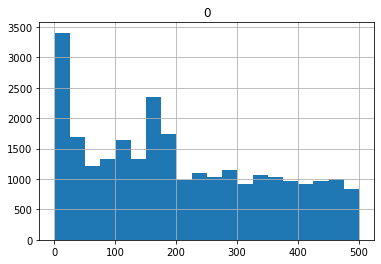

In [6]:
# Examine discovered facts, histogram
print(len(facts[0]), facts)
print( facts[0][ facts[1].tolist().index( min(facts[1]) ) ] )

facts_df = pd.DataFrame(facts[1].tolist())
facts_df.hist(bins=20)

In [16]:
X_removed_subs = [list(f)[0] for f in X_removed]
X_subs = [list(f)[0] for f in X]
# '(Q2106616) Potters Bar Town F.C.' in X_removed_subs  # False
'(Q2106616) Potters Bar Town F.C.' in X_subs  # True

True

In [15]:
[f for f in X if f[0] == '(Q1772619) Navua F.C.']

[array(['(Q1772619) Navua F.C.', '(P31) instance of',
        '(Q476028) association football club'], dtype=object),
 array(['(Q1772619) Navua F.C.', '(P118) league',
        '(Q1520528) Fiji Premier League'], dtype=object),
 array(['(Q1772619) Navua F.C.', '(P641) sport',
        '(Q2736) association football'], dtype=object),
 array(['(Q1772619) Navua F.C.', '(P115) home venue',
        '(Q16852186) Thomson Park'], dtype=object),
 array(['(Q1772619) Navua F.C.', '(P17) country', '(Q712) Fiji'],
       dtype=object)]

---
<div class="alert alert-block alert-info">
<b>Results below:</b>
</div>

- `X[:10_000], top_n=500, max_candidates=1_000, strategy='entity_frequency'`
    - Predicted, acc. positive triples: 13 / 723 or 1.798063623789765 %
    
- `X[:10_000], top_n=500, max_candidates=100_000, strategy='entity_frequency'`
    - Predicted, acc. positive triples: 86 / 723 or 11.894882434301522 %

- `X[:10_000], top_n=500, max_candidates=100_000, strategy='graph_degree'`
    - Predicted, acc. positive triples: 73 / 723 or 10.096818810511756 %
    
- `X[:10_000], top_n=500, max_candidates=100_000, strategy='cluster_coefficient'`, 
    - `cluster_coefficient` performs worst
    - None
    
    
- `X[:10_000], top_n=500, max_candidates=5_000, strategy='graph_degree'`, 
    - Predicted, acc. positive triples: 110 / 271 or 40.59040590405904 %
    - Predicted, extant positive triples: 128 / 271 or 47.23247232472325 %

- Good predictions: only 1 positive triple, top_n=500, max_candidates=500_000, strategy='graph_degree'
```{note}
[(1.0, "['(Q12168) Sociedad Deportiva Ponferradina', '(P641) sport', '(Q2736) association football']"),
/InTrain: (1.0, "['(Q2756) Robur Siena', '(P641) sport', '(Q2736) association football']"),
 (1.5, "['(Q18274) F.C. United of Manchester', '(P641) sport', '(Q2736) association football']"),
 (3.0, "['(Q17228) Catalonia national football team', '(P641) sport', '(Q2736) association football']"),
 (3.0, "['(Q6767) A.S. Livorno', '(P641) sport', '(Q2736) association football']"),
 (4.0, "['(Q8760) Deportivo de La Coruña', '(P641) sport', '(Q2736) association football']"),
 (6.5, "['(Q11997) Club Deportivo Mirandés', '(P641) sport', '(Q2736) association football']"),
 (84.0, "['(Q11938) PSV Eindhoven', '(P641) sport', '(Q2736) association football']")]
```

- Good predictions: 4 positive triples, top_n=500, max_candidates=500_000, strategy='graph_degree'
```{note}
[(1.0, //  "['(Q11997) Club Deportivo Mirandés', '(P641) sport', '(Q2736) association football']"),
 (1.0, "['(Q12168) Sociedad Deportiva Ponferradina', '(P641) sport', '(Q2736) association football']"),
 (1.0, //  "['(Q17228) Catalonia national football team', '(P641) sport', '(Q2736) association football']"),
 (1.0, //  "['(Q2756) Robur Siena', '(P641) sport', '(Q2736) association football']"),
 (1.0, //  "['(Q8760) Deportivo de La Coruña', '(P641) sport', '(Q2736) association football']"),
 (1.5, "['(Q18274) F.C. United of Manchester', '(P641) sport', '(Q2736) association football']"),
 (28.0, "['(Q11938) PSV Eindhoven', '(P641) sport', '(Q2736) association football']"),
 (40.5, "['(Q6767) A.S. Livorno', '(P641) sport', '(Q2736) association football']")]
```
"""

## Testing on `wd-triples-P31-obj-set-sports-season-sporting-event`

In [3]:
!wc -l wd-triples-P31-obj-set-sports-season-sporting-event-labeled.tsv
!head wd-triples-P31-obj-set-sports-season-sporting-event-labeled.tsv

843898 wd-triples-P31-obj-set-sports-season-sporting-event-labeled.tsv
sub	pred	obj
(Q3190) 2012 Rhythmic Gymnastics European Championships	(P641) sport	(Q61465) rhythmic gymnastics
(Q3190) 2012 Rhythmic Gymnastics European Championships	(P3450) sports season of league or competition	(Q1281845) Rhythmic Gymnastics European Championships
(Q3190) 2012 Rhythmic Gymnastics European Championships	(P31) instance of	(Q27020041) sports season
(Q3190) 2012 Rhythmic Gymnastics European Championships	(P2094) competition class	(Q920057) women's sports
(Q3190) 2012 Rhythmic Gymnastics European Championships	(P664) organizer	(Q673212) European Gymnastics
(Q3190) 2012 Rhythmic Gymnastics European Championships	(P276) location	(Q891) Nizhny Novgorod
(Q4665) Colombian Championship 1962	(P641) sport	(Q2736) association football
(Q4665) Colombian Championship 1962	(P31) instance of	(Q27020041) sports season
(Q4665) Colombian Championship 1962	(P3450) sports season of league or competition	(Q1033349) Cate

In [ ]:
%%time
# Grid search for model
"""
wd-triples-P31-obj-set-sports-season-sporting-event-labeled.tsv
Entities: 230916 , Relations: 128
Set sizes: Train: 801497 , Test: 42184

Average Loss:   0.050622: 100%|██████████| 200/200 [1:41:32<00:00, 30.46s/epoch]
100%|██████████| 42184/42184 [36:46<00:00, 19.12it/s]  

MRR: 0.62
Hits@50: 0.99
Hits@10: 0.75
Hits@3: 0.64
Hits@1: 0.55
CPU times: user 8h 16min 22s, sys: 2h 31min 49s, total: 10h 48min 11s
Wall time: 2h 19min 53s

...
ComplEx {'batches_count': 20, 'seed': 0, 'epochs': 100, 'k': 150, 'eta': 2, 'loss': 'pairwise', 'regularizer': 'LP', 'optimizer': 'adam', 'verbose': True, 'loss_params': {'margin': 20}, 'optimizer_params': {'lr': 0.01}, 'embedding_model_params': {'negative_corruption_entities': 'all'}, 'regularizer_params': {'p': 2, 'lambda': 0.001}} 0.43563090542800964 {'mrr': 0.4378237728810778, 'mr': 13.562606675516784, 'hits_1': 0.34107718566281053, 'hits_3': 0.45064479423478093, 'hits_10': 0.6582590555660914}

"""
import numpy as np
import warnings   # silence numpy warnings
warnings.filterwarnings('ignore')
import pandas as pd
import ampligraph
from ampligraph.datasets import load_from_csv
from ampligraph.discovery import discover_facts
from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.evaluation import select_best_model_ranking
from ampligraph.evaluation import evaluate_performance, mr_score, mrr_score, hits_at_n_score
from ampligraph.latent_features import ComplEx, ConvE, TransE
from ampligraph.latent_features import save_model, restore_model
from ampligraph.utils import create_tensorboard_visualizations
import tensorflow as tf
import random

variant = 'ComplEx-sports-season-sporting-event'
data = 'wd-triples-P31-obj-set-sports-season-sporting-event-labeled.tsv'

# Load data
print(data)
X = load_from_csv('', data, sep='\t', header=1)
entities = np.unique(np.concatenate([X[:, 0], X[:, 2]]))
random_entites = random.sample(list(entities), 30)
relations = np.unique(X[:, 1])
print('Entities:', len(entities), ', Relations:', len(relations))

# Training/test split
num_test = int(len(X) * 0.05)  # Test size affects time to complete
data = {}
data['train'], data['test'] = train_test_split_no_unseen(X, test_size=num_test, seed=0, allow_duplication=False)
# print("Set sizes: Train:", len(data['train']), ", Test:", len(data['test']) )
data['train'], data['valid'] = train_test_split_no_unseen(data['train'], test_size=num_test)
print("Set sizes: Train:", len(data['train']), ", Test:", len(data['test']), ", Validation:", len(data['valid']) )

#### Grid Search - Model hyperparameters
model_class = ComplEx

# Use the template given below for doing grid search. 
param_grid = {"batches_count": [20],
              "seed": 0,
              "epochs": [100],
              "k": [150],
              "eta": [2, 5],
              "loss": ["pairwise", "nll", "self_adversarial", "multiclass_nll"],
              # We take care of mapping the params to corresponding classes
              "loss_params": {
                 #margin corresponding to both pairwise and adverserial loss
                 "margin": [0.5, 20], 
                 #alpha corresponding to adverserial loss
                 "alpha": [0.5]
              },
              "embedding_model_params": {
                 # generate corruption using all entities during training
                 "negative_corruption_entities":"all"
              },
              "regularizer": [None, "LP"],
              "regularizer_params": {
                 "p": [2],
                 "lambda": [1e-3, 1e-5]
              },
              "optimizer": ["adam"],
              "optimizer_params":{
                 "lr": [0.1, 0.01]
              },
              "verbose": True
             }
# Train the model on all possibile combinations of hyperparameters.
# Models are validated on the validation set.
# It returnes a model re-trained on training and validation sets.
best_model, best_params, best_mrr_train, ranks_test, \
mrr_test, experimental_history = select_best_model_ranking(model_class,
                                                 data['train'],
                                                 data['valid'],
                                                 data['test'], 
                                                 param_grid,      
                                                 # Use filtered set for eval
                                                 use_filter=False,
                                                 entities_subset=random_entites,
                                                 corrupt_side='s+o', # Replaces use_default_protocol
                                                 verbose=True)

print(type(best_model).__name__, best_params, best_mrr_train, mrr_test)

"""model = ComplEx(batches_count=20, # 200, 100, 50
                seed=0, 
                epochs=200,  # 200
                k=150, 
                eta=2,  # 5 - the number of negative, or false triples that must be generated at training runtime for each positive triple
                optimizer='adam', # adam, sdg
                optimizer_params={'lr':1e-3},
                loss='multiclass_nll', 
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                verbose=True)"""

# positives_filter - Checking that negative statements are in fact negative
filter1 = np.concatenate((data['train'], data['test'], data['valid'] )) if data.get('valid') else np.concatenate((data['train'], data['test'] ))

# Saving model
save_model(best_model, './model-gridsearched-'+ variant +'.pkl')

# Tensorboard model
create_tensorboard_visualizations(best_model, 'tensorboard_files-' + variant)

#### Evaluate
ranks = evaluate_performance(data['test'], 
                             model=best_model,
                             filter_unseen=True,  # could be False since train_test_split_unseen() used
                             entities_subset=random_entites , #entities[:100],
                             filter_triples=filter1, # Corruption strategy filter defined above 
                             #use_default_protocol=True, # default: False, If True, corrupt_side is ‘s,o’
                             corrupt_side='s+o', # Replaces use_default_protocol
                             verbose=True)

mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))
hits_50 = hits_at_n_score(ranks, n=50)
print("Hits@50: %.2f" % (hits_50))
hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

In [19]:
# Verify best_model performance
filter1 = np.concatenate((data['train'], data['test'], data['valid'] ))

ranks = evaluate_performance(data['test'], 
                             model=best_model,
                             filter_unseen=True,  # could be False since train_test_split_unseen() used
                             entities_subset=random_entites , #entities[:100],
                             filter_triples=filter1, # Corruption strategy filter defined above 
                             #use_default_protocol=True, # default: False, If True, corrupt_side is ‘s,o’
                             corrupt_side='s+o', # Replaces use_default_protocol
                             verbose=True)

mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))
hits_50 = hits_at_n_score(ranks, n=50)
print("Hits@50: %.2f" % (hits_50))
hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

100%|██████████| 42184/42184 [36:55<00:00, 19.04it/s]  


MRR: 0.56
Hits@50: 0.98
Hits@10: 0.74
Hits@3: 0.59
Hits@1: 0.47


In [23]:
print(len(experimental_history))
experimental_history

72


[{'model_name': 'ComplEx',
  'model_params': {'batches_count': 20,
   'seed': 0,
   'epochs': 100,
   'k': 150,
   'eta': 2,
   'loss': 'pairwise',
   'regularizer': None,
   'optimizer': 'adam',
   'verbose': True,
   'loss_params': {'margin': 0.5},
   'optimizer_params': {'lr': 0.1},
   'embedding_model_params': {'negative_corruption_entities': 'all'},
   'regularizer_params': {}},
  'results': {'mrr': 0.36530323989824626,
   'mr': 11.96171534230988,
   'hits_1': 0.2486724824578039,
   'hits_3': 0.38135311966622415,
   'hits_10': 0.63860705480751}},
 {'model_name': 'ComplEx',
  'model_params': {'batches_count': 20,
   'seed': 0,
   'epochs': 100,
   'k': 150,
   'eta': 2,
   'loss': 'pairwise',
   'regularizer': None,
   'optimizer': 'adam',
   'verbose': True,
   'loss_params': {'margin': 0.5},
   'optimizer_params': {'lr': 0.01},
   'embedding_model_params': {'negative_corruption_entities': 'all'},
   'regularizer_params': {}},
  'results': {'mrr': 0.39697623513145897,
   'mr': 14.

### `discover_facts()`

In [58]:
%%time
# Using best_model parameters
"""
# Testing discover_facts on best_model parameters:
ComplEx {'batches_count': 20, 'seed': 0, 'epochs': 100, 'k': 150, 'eta': 2, 'loss': 'pairwise', 
'regularizer': 'LP', 'optimizer': 'adam', 'verbose': True, 'loss_params': {'margin': 20}, 
'optimizer_params': {'lr': 0.01}, 'embedding_model_params': {'negative_corruption_entities': 'all'}, 
'regularizer_params': {'p': 2, 'lambda': 0.001}} 0.43563090542800964 
{'mrr': 0.4378237728810778, 'mr': 13.562606675516784, 
'hits_1': 0.34107718566281053, 'hits_3': 0.45064479423478093, 'hits_10': 0.6582590555660914}

"""
import numpy as np
# import warnings   # silence numpy warnings
# warnings.filterwarnings('ignore')
import pandas as pd
import ampligraph
from ampligraph.datasets import load_from_csv
from ampligraph.discovery import discover_facts
from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.evaluation import select_best_model_ranking
from ampligraph.evaluation import evaluate_performance, mr_score, mrr_score, hits_at_n_score
from ampligraph.latent_features import ComplEx, ConvE, TransE
from ampligraph.latent_features import save_model, restore_model
from ampligraph.utils import create_tensorboard_visualizations
import tensorflow as tf
import random

variant = 'ComplEx-sports-season-sporting-event'
data = 'wd-triples-P31-obj-set-sports-season-sporting-event-labeled.tsv'

# Load data
print(data)
X = load_from_csv('', data, sep='\t', header=1)[:50_000]  #[-50_00:]  #[:50_000]  # TEST smaller load
entities = np.unique(np.concatenate([X[:, 0], X[:, 2]]))
random_entites = random.sample(list(entities), 30)
relations = np.unique(X[:, 1])
print('Entities:', len(entities), ', Relations:', len(relations))

# Training/test split
num_test = int(len(X) * 0.05)  # Test size affects time to complete
data = {}
data['train'], data['test'] = train_test_split_no_unseen(X, test_size=num_test, seed=0, allow_duplication=False)
# print("Set sizes: Train:", len(data['train']), ", Test:", len(data['test']) )
data['train'], data['valid'] = train_test_split_no_unseen(data['train'], test_size=num_test)
print("Set sizes: Train:", len(data['train']), ", Test:", len(data['test']), ", Validation:", len(data['valid']) )


# ComplEx {'batches_count': 20, 'seed': 0, 'epochs': 100, 'k': 150, 'eta': 2, 
# 'loss': 'pairwise', 'regularizer': 'LP', 'optimizer': 'adam', 'verbose': True, 
# 'loss_params': {'margin': 20}, 'optimizer_params': {'lr': 0.01}, 
# 'embedding_model_params': {'negative_corruption_entities': 'all'}, 
# 'regularizer_params': {'p': 2, 'lambda': 0.001}} 
# {'mrr': 0.4378237728810778, 'mr': 13.562606675516784, 
# 'hits_1': 0.34107718566281053, 'hits_3': 0.45064479423478093, 'hits_10': 0.6582590555660914}
model = ComplEx(batches_count=20,
                seed=0, 
                epochs=300,  # 100
                k=150, 
                eta=2,  # 5 - the number of negative, or false triples that must be generated at training runtime for each positive triple
                optimizer='adam', # adam, sdg
                optimizer_params={'lr':1e-2},
                loss='pairwise', 
                loss_params={'margin': 20},
                regularizer='LP', 
                regularizer_params={'p':2, 'lambda':1e-3}, 
                verbose=True)


# positives_filter - Checking that negative statements are in fact negative
filter1 = np.concatenate((data['train'], data['test'], data.get('valid') ))

# Saving model
# save_model(best_model, './model-gridsearched-'+ variant +'.pkl')
# Tensorboard model
# create_tensorboard_visualizations(best_model, 'tensorboard_files-' + variant)

wd-triples-P31-obj-set-sports-season-sporting-event-labeled.tsv
Entities: 19389 , Relations: 60
Set sizes: Train: 45000 , Test: 2500 , Validation: 2500
CPU times: user 1.38 s, sys: 88 ms, total: 1.47 s
Wall time: 2.31 s


In [59]:
print(len(relations))
relations

60


array(['(P115) home venue', '(P118) league', '(P1269) facet of',
       '(P131) located in the administrative territorial entity',
       '(P1344) participant in', '(P1346) winner',
       "(P1424) topic's main template", '(P1427) start point',
       '(P1444) destination point', '(P155) follows',
       '(P1552) has quality', '(P156) followed by',
       '(P159) headquarters location', '(P1652) referee', '(P17) country',
       '(P179) part of the series', '(P1889) different from',
       '(P1923) participating team', '(P2094) competition class',
       '(P2283) uses', '(P2348) time period',
       '(P2416) sports discipline competed in',
       '(P2499) league level above', '(P2500) league level below',
       '(P2501) results', '(P2541) operating area',
       '(P2670) has parts of the class', '(P276) location',
       '(P279) subclass of', '(P2881) promoted', '(P2882) relegated',
       '(P30) continent', '(P3085) qualifies for event',
       '(P31) instance of', '(P3195) league po

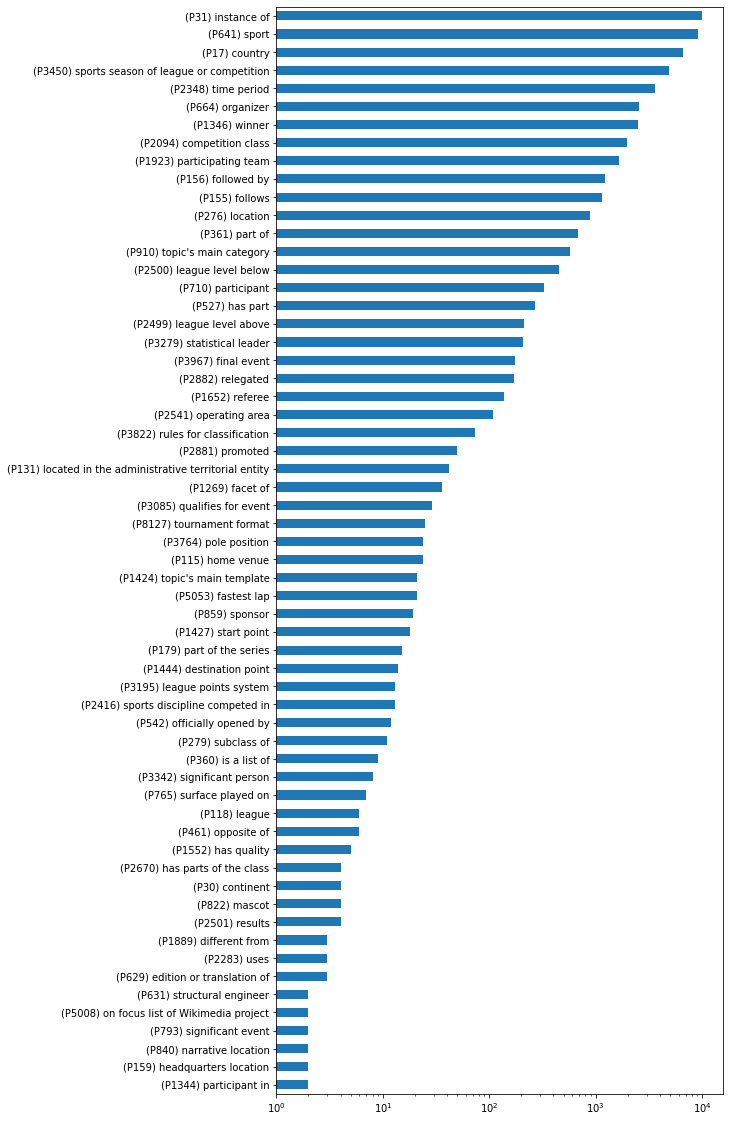

In [60]:
# histogram
import pandas as pd

lst = X[:, 1].tolist()
df = pd.DataFrame(lst)
df[0].value_counts().sort_values().plot(kind='barh', log=True, figsize=(8,20))

In [ ]:
# Tried reducing original X data
# X_filtered = [ list(fact) for fact in X if fact[1] == '(P31) instance of' or 
#                             fact[1] == '(P641) sport' or
#                             fact[1] == '(P17) country' or
#                             fact[1] == '(P3450) sports season of league or competition' or
#                             fact[1] == '(P2348) time period' 
# ]
# X2 = np.array(X_filtered)
# print(len(X2))
# X2

In [ ]:
# discover_facts()
X2 = X
model.fit(X2, early_stopping=False)

# relations = [ '(P31) instance of',
#     '(P641) sport',
#     '(P17) country',
#     '(P3450) sports season of league or competition',
#     '(P2348) time period' ]

for relation in relations:
    try:  # skip relations not in facts
        facts = discover_facts(X2, model, top_n=500, max_candidates=800_000, #700, 
               # 'random_uniform', 'entity_frequency', 'graph_degree', 'cluster_coefficient', 'cluster_triangles', 'cluster_squares'
               strategy='entity_frequency',
               target_rel=relation, seed=42)
        facts
    except:
        pass

In [62]:
%%time
# discover_facts() - TESTING: discover P31 "instance of" relation
# reducing original X data
X = [ list(fact) for fact in X if fact[1] == '(P31) instance of' or 
                            fact[1] == '(P641) sport' or
                            fact[1] == '(P17) country' or
                            fact[1] == '(P118) league '  ]
X_filtered = []
counter = 0
for i in range(len(X)):
    if X[i][1] == '(P641) sport' and counter % 2 == 0:
        X_filtered.append(X[i])
        counter += 1
    if X[i][1] == '(P641) sport' and counter % 2 != 0:
        pass
    else:
        X_filtered.append(X[i])
X2 = np.array(X_filtered)
print(len(X2), X2)

# X2 = X
model.fit(X2, early_stopping=False)

relations = [ '(P641) sport' ]
for relation in relations:
    facts2 = discover_facts(X2, model, top_n=500, max_candidates=100_000,
               # 'random_uniform', 'entity_frequency', 'graph_degree', 'cluster_coefficient', 'cluster_triangles', 'cluster_squares'
               strategy='entity_frequency',  # graph_degree worked!
               target_rel=relation, seed=42)
    print(len(facts2[0]), facts2)

16534 [['(Q3190) 2012 Rhythmic Gymnastics European Championships'
  '(P31) instance of' '(Q27020041) sports season']
 ['(Q4665) Colombian Championship 1962' '(P641) sport'
  '(Q2736) association football']
 ['(Q4665) Colombian Championship 1962' '(P31) instance of'
  '(Q27020041) sports season']
 ...
 ['(Q15804251) nan' '(P17) country' '(Q16957) German Democratic Republic']
 ['(Q15804251) nan' '(P31) instance of' '(Q27020041) sports season']
 ['(Q15804263) nan' '(P17) country' '(Q16957) German Democratic Republic']]


Average Loss:   5.128649: 100%|██████████| 300/300 [05:32<00:00,  1.11s/epoch]


WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████| 100000/100000 [1:04:49<00:00, 25.71it/s]


2492 (array([["(Q7657610) swimming at the 2006 Commonwealth Games – women's 50 metres butterfly",
        '(P641) sport', '(Q27020041) sports season'],
       ["(Q7657610) swimming at the 2006 Commonwealth Games – women's 50 metres butterfly",
        '(P641) sport', '(Q27020041) sports season'],
       ["(Q7657610) swimming at the 2006 Commonwealth Games – women's 50 metres butterfly",
        '(P641) sport', '(Q27020041) sports season'],
       ...,
       ["(Q7500901) shooting at the 2010 Commonwealth Games – men's 25 metre centre fire pistol pairs",
        '(P641) sport', '(Q38) Italy'],
       ["(Q4593522) 1998 European Athletics Championships – men's 1500 metres",
        '(P641) sport', '(Q38) Italy'],
       ["(Q14255901) swimming at the 2013 World Aquatics Championships – men's 50 metre freestyle",
        '(P641) sport', '(Q38) Italy']], dtype=object), array([364.5, 364.5, 364.5, ..., 450. , 464.5, 431. ]))
CPU times: user 5h 48min 50s, sys: 29min 44s, total: 6h 18min 35s
Wa

In [66]:
# Examine discovered facts
facts2[0]

2492 (array([["(Q7657610) swimming at the 2006 Commonwealth Games – women's 50 metres butterfly",
        '(P641) sport', '(Q27020041) sports season'],
       ["(Q7657610) swimming at the 2006 Commonwealth Games – women's 50 metres butterfly",
        '(P641) sport', '(Q27020041) sports season'],
       ["(Q7657610) swimming at the 2006 Commonwealth Games – women's 50 metres butterfly",
        '(P641) sport', '(Q27020041) sports season'],
       ...,
       ["(Q7500901) shooting at the 2010 Commonwealth Games – men's 25 metre centre fire pistol pairs",
        '(P641) sport', '(Q38) Italy'],
       ["(Q4593522) 1998 European Athletics Championships – men's 1500 metres",
        '(P641) sport', '(Q38) Italy'],
       ["(Q14255901) swimming at the 2013 World Aquatics Championships – men's 50 metre freestyle",
        '(P641) sport', '(Q38) Italy']], dtype=object), array([364.5, 364.5, 364.5, ..., 450. , 464.5, 431. ]))


In [68]:
# Sort by statement rank
facts_dict = {}
facts_statements = facts2[0].tolist()
facts_ranks = facts2[1].tolist()

for i in range( len(facts_statements) ):
    facts_dict[ str(list(facts_statements[i])) ] = facts_ranks[i]

facts_dict
sorted((value,key) for (key,value) in facts_dict.items())

[(10.0,
  '["(Q7500901) shooting at the 2010 Commonwealth Games – men\'s 25 metre centre fire pistol pairs", \'(P641) sport\', \'(Q27) Ireland\']'),
 (12.0,
  '["(Q4580420) 1982 European Athletics Championships – men\'s triple jump", \'(P641) sport\', \'(Q183) Germany\']'),
 (12.5,
  '["(Q14255901) swimming at the 2013 World Aquatics Championships – men\'s 50 metre freestyle", \'(P641) sport\', \'(Q736) Ecuador\']'),
 (13.5,
  '["(Q4580420) 1982 European Athletics Championships – men\'s triple jump", \'(P641) sport\', \'(Q213) Czech Republic\']'),
 (17.5,
  '["(Q7500901) shooting at the 2010 Commonwealth Games – men\'s 25 metre centre fire pistol pairs", \'(P641) sport\', \'(Q17) Japan\']'),
 (20.0,
  '["(Q1187665) swimming at the 2009 World Aquatics Championships – women\'s 200 metre breaststroke", \'(P641) sport\', \'(Q214) Slovakia\']'),
 (22.5,
  '["(Q4580420) 1982 European Athletics Championships – men\'s triple jump", \'(P641) sport\', \'(Q414) Argentina\']'),
 (23.0,
  '["(Q1425

In [ ]:
""" Results Log:

100%|██████████| 700/700 [10:01<00:00,  1.16it/s]
(array([['(Q28499155) nan',
         '(P3450) sports season of league or competition',
         '(Q41466) ice hockey'],
        ["(Q838683) 1989–90 European Cup Winners' Cup",
         '(P3450) sports season of league or competition',
         "(Q31930761) men's association football"]], dtype=object),
 array([200.5, 133. ]))

100%|██████████| 500/500 [06:49<00:00,  1.22it/s]
(array([['(Q20045257) nan', '(P31) instance of', '(Q16) Canada'],
        ['(Q11782724) nan', '(P31) instance of',
         '(Q27020041) sports season'],
        ['(Q11782724) nan', '(P31) instance of',
         '(Q2736) association football'],
        ['(Q30589987) 2014–15 Top League Challenge Series',
         '(P31) instance of', '(Q12841927) National Gymnastics Arena'],
        ['(Q11782724) nan', '(P31) instance of',
         '(Q27020041) sports season'],
        ['(Q11782724) nan', '(P31) instance of',
         '(Q2736) association football']], dtype=object),
 array([493. , 205. , 207.5, 117.5, 205. , 207.5]))

100%|██████████| 500/500 [06:46<00:00,  1.23it/s]
(array([['(Q30904863) nan', '(P106) occupation', '(Q145) United Kingdom'],
        ['(Q3060646) Euroleague Women 1998–99', '(P106) occupation',
         '(Q145) United Kingdom'],
        ["(Q16968027) wushu at the 2002 Asian Games – men's taijiquan",
         '(P106) occupation', '(Q881) Vietnam'],
        ['(Q20097378) nan', '(P106) occupation', '(Q41466) ice hockey'],
        ['(Q16822962) 1972–73 Football League First Division',
         '(P106) occupation', '(Q16510064) sporting event'],
        ['(Q3060646) Euroleague Women 1998–99', '(P106) occupation',
         '(Q2736) association football'],
        ['(Q42322855) 2018 NRL season', '(P106) occupation',
         '(Q6961122) Nam Nguyen'],
        ['(Q28499155) nan', '(P106) occupation', '(Q39080949) nan']],
       dtype=object),

100%|██████████| 500/500 [06:40<00:00,  1.25it/s]
(array([["(Q482592) 2010 European Women's Handball Championship",
         '(P4908) season', '(Q41466) ice hockey'],
        ['(Q20097378) nan', '(P4908) season', '(Q41466) ice hockey'],
        ["(Q16451) 2003 UCI Women's Road World Cup", '(P4908) season',
         '(Q2736) association football'],
        ["(Q16451) 2003 UCI Women's Road World Cup", '(P4908) season',
         '(Q2736) association football']], dtype=object),
 array([200. , 217.5, 216.5, 216.5]))

100%|██████████| 500/500 [06:42<00:00,  1.24it/s]
(array([['(Q20097378) nan', '(P641) sport', '(Q6961122) Nam Nguyen'],
        ['(Q3923643) nan', '(P641) sport', '(Q2736) association football']],
       dtype=object), array([209.5,  77.5]))

100%|██████████| 700/700 [10:06<00:00,  1.15it/s]
(array([['(Q56389885) nan', '(P664) organizer',
         '(Q16510064) sporting event']], dtype=object), array([275.5]))

"""

### `discover_facts()` on GoT

In [7]:
# GoT test
import requests
from ampligraph.datasets import load_from_csv
from ampligraph.latent_features import ComplEx
from ampligraph.discovery import discover_facts

X2 = load_from_csv('.', 'GoT.csv', sep=',')
entities = np.unique(np.concatenate([X[:, 0], X[:, 2]]))
random_entites = random.sample(list(entities), 30)
relations = np.unique(X[:, 1])
print('Entities:', len(entities), ', Relations:', len(relations))

model = ComplEx(batches_count=10, seed=0, epochs=200, k=150, eta=5,
                 optimizer='adam', optimizer_params={'lr':1e-3},
                 loss='multiclass_nll', regularizer='LP',
                 regularizer_params={'p':3, 'lambda':1e-5},
                 verbose=True)
model.fit(X2)

discover_facts(X2, model, top_n=3, max_candidates=20000, strategy='entity_frequency',
                target_rel='ALLIED_WITH', seed=42)

Entities: 727 , Relations: 40


Average Loss:   0.016880: 100%|██████████| 200/200 [00:31<00:00,  6.37epoch/s]


WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████| 20000/20000 [02:31<00:00, 132.25it/s]


(array([['Renly Baratheon', 'ALLIED_WITH', 'House Tyrell of Highgarden'],
        ['Barth', 'ALLIED_WITH', 'House Stark of Winterfell'],
        ['Brienne of Tarth', 'ALLIED_WITH', 'House Stark of Winterfell'],
        ['Myriame Manderly', 'ALLIED_WITH', 'House Stark of Winterfell'],
        ['Lyanna Stark', 'ALLIED_WITH', 'House Stark of Winterfell'],
        ['Domeric Bolton', 'ALLIED_WITH', 'House Bolton of the Dreadfort'],
        ['Baelon Targaryen', 'ALLIED_WITH',
         "House Targaryen of King's Landing"],
        ['Barth', 'ALLIED_WITH', "House Targaryen of King's Landing"],
        ['Alyssa Velaryon', 'ALLIED_WITH',
         "House Targaryen of King's Landing"],
        ['Aegon Targaryen', 'ALLIED_WITH',
         "House Targaryen of King's Landing"],
        ['Jaehaera Targaryen', 'ALLIED_WITH',
         "House Targaryen of King's Landing"],
        ['Alyn Velaryon', 'ALLIED_WITH',
         "House Targaryen of King's Landing"],
        ['Betha Blackwood', 'ALLIED_WITH',
   

In [8]:
print([f for f in X2 if f[0] == 'Renly Baratheon'], '\n\n', 
      [f for f in X2 if f[0] == 'Margaery Tyrell'] )

[array(['Renly Baratheon', 'ALLIED_WITH', "House Baratheon of Storm's End"],
      dtype=object), array(['Renly Baratheon', 'SPOUSE', 'Margaery Tyrell'], dtype=object)] 

 [array(['Margaery Tyrell', 'SPOUSE', 'Joffrey Baratheon'], dtype=object), array(['Margaery Tyrell', 'ALLIED_WITH', 'House Tyrell of Highgarden'],
      dtype=object)]


## ...
## Testing on `wd-triples-P31-obj-set-space-galaxy-star`

In [12]:
# !wc -l wd-triples-P31-obj-set-space-galaxy-star-labeled.tsv
# !head wd-triples-P31-obj-set-space-galaxy-star-labeled.tsv
! wc -l wd-triples-P31-obj-set-space-galaxy-star-2literal-20K-labeled.tsv
!head -100 wd-triples-P31-obj-set-space-galaxy-star-2literal-20K-labeled.tsv
# !wc -l wd-triples-P31-obj-set-space-galaxy-2literal-20K-labeled.tsv
# !head wd-triples-P31-obj-set-space-galaxy-2literal-20K-labeled.tsv

20001 wd-triples-P31-obj-set-space-galaxy-star-2literal-20K-labeled.tsv
SUB_sub	pred	obj
SUB_(Q33110) Ursa Major II Dwarf	(hasLabelru) 	(Ursa Major II Dwarf) 
SUB_(Q33110) Ursa Major II Dwarf	(hasLabelfr) 	(Ursa Major II) 
SUB_(Q33110) Ursa Major II Dwarf	(hasLabelen) 	(Ursa Major II Dwarf) 
SUB_(Q33110) Ursa Major II Dwarf	(hasLabelpt) 	(Galáxia Anã da Ursa Maior II) 
SUB_(Q33110) Ursa Major II Dwarf	(hasLabelaf) 	(Ursa Major II-dwergsterrestelsel) 
SUB_(Q33110) Ursa Major II Dwarf	(hasLabelko) 	(큰곰자리 II 왜소은하) 
SUB_(Q33110) Ursa Major II Dwarf	(hasLabelde) 	(Ursa-Major-II-Zwerggalaxie) 
SUB_(Q33110) Ursa Major II Dwarf	(hasLabeltr) 	(Büyük Ayı Cüce Gökadası II) 
SUB_(Q33110) Ursa Major II Dwarf	(hasLabelit) 	(Galassia Nana Ursa Major II) 
SUB_(Q33110) Ursa Major II Dwarf	(hasLabelfi) 	(Ison karhun II kääpiögalaksi) 
SUB_(Q33110) Ursa Major II Dwarf	(hasLabelpl) 	(Karzeł Wielkiej Niedźwiedzicy II) 
SUB_(Q33110) Ursa Major II Dwarf	(hasLabelsk) 	(Veľký voz) 
SUB_(Q33110) Ursa Major II D

In [19]:
# !sed -i 's/nan//g' wd-triples-P31-obj-set-space-galaxy-star-labeled.tsv
# !sed -i 's/nan//g' wd-triples-P31-obj-set-space-galaxy-star-2literal-20K-labeled.tsv
!sed -i 's/nan//g' wd-triples-P31-obj-set-space-galaxy-2literal-20K-labeled.tsv

In [21]:
# !sed -i -e 's/^/SUB_/' wd-triples-P31-obj-set-space-galaxy-star-2literal-20K-labeled.tsv
!sed -i -e 's/^/SUB_/' wd-triples-P31-obj-set-space-galaxy-2literal-20K-labeled.tsv

In [7]:
# For GraphIt Explorer
import warnings   # silence numpy warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from ampligraph.datasets import load_from_csv

# data = 'wd-triples-P31-obj-set-space-galaxy-star-labeled.tsv'
data = 'wd-triples-P31-obj-set-space-galaxy-star-2literal-20K-labeled.tsv'

# Load data
print(data)
X = load_from_csv('', data, sep='\t', header=1)
entities = np.unique(np.concatenate([X[:, 0], X[:, 2]]))
relations = np.unique(X[:, 1])
print('Entities: ', len(entities), '; Relations: ', len(relations))

for i in X[:100]:
    # IF not label:
    
    print(i[0], ';', i[1], ';', i[2])

wd-triples-P31-obj-set-space-galaxy-star-2literal-20K-labeled.tsv
Entities:  6227 ; Relations:  91
SUB_(Q33110) Ursa Major II Dwarf ; (hasLabelfr)  ; (Ursa Major II) 
SUB_(Q33110) Ursa Major II Dwarf ; (hasLabelen)  ; (Ursa Major II Dwarf) 
SUB_(Q33110) Ursa Major II Dwarf ; (hasLabelpt)  ; (Galáxia Anã da Ursa Maior II) 
SUB_(Q33110) Ursa Major II Dwarf ; (hasLabelaf)  ; (Ursa Major II-dwergsterrestelsel) 
SUB_(Q33110) Ursa Major II Dwarf ; (hasLabelko)  ; (큰곰자리 II 왜소은하) 
SUB_(Q33110) Ursa Major II Dwarf ; (hasLabelde)  ; (Ursa-Major-II-Zwerggalaxie) 
SUB_(Q33110) Ursa Major II Dwarf ; (hasLabeltr)  ; (Büyük Ayı Cüce Gökadası II) 
SUB_(Q33110) Ursa Major II Dwarf ; (hasLabelit)  ; (Galassia Nana Ursa Major II) 
SUB_(Q33110) Ursa Major II Dwarf ; (hasLabelfi)  ; (Ison karhun II kääpiögalaksi) 
SUB_(Q33110) Ursa Major II Dwarf ; (hasLabelpl)  ; (Karzeł Wielkiej Niedźwiedzicy II) 
SUB_(Q33110) Ursa Major II Dwarf ; (hasLabelsk)  ; (Veľký voz) 
SUB_(Q33110) Ursa Major II Dwarf ; (hasLabel

In [22]:
# Add text for subject item types: galaxy (g) ; star (s)
galaxy = [ f[0] for f in X if f[1] == '(P31) instance of' and f[2] == '(Q318) galaxy']
star = [ f[0] for f in X if f[1] == '(P31) instance of' and f[2] == '(Q523) star']
X2 = []
for ln in X:
    if ln[0] in galaxy:
        X2.append( [ 'g_' + ln[0], ln[1], ln[2] ])
    elif ln[0] in star:
        X2.append( [ 's_' + ln[0], ln[1], ln[2] ])

X = np.array(X2)
X2

[['g_SUB_(Q33110) Ursa Major II Dwarf', '(hasLabelfr) ', '(Ursa Major II) '],
 ['g_SUB_(Q33110) Ursa Major II Dwarf',
  '(hasLabelen) ',
  '(Ursa Major II Dwarf) '],
 ['g_SUB_(Q33110) Ursa Major II Dwarf',
  '(hasLabelpt) ',
  '(Galáxia Anã da Ursa Maior II) '],
 ['g_SUB_(Q33110) Ursa Major II Dwarf',
  '(hasLabelaf) ',
  '(Ursa Major II-dwergsterrestelsel) '],
 ['g_SUB_(Q33110) Ursa Major II Dwarf', '(hasLabelko) ', '(큰곰자리 II 왜소은하) '],
 ['g_SUB_(Q33110) Ursa Major II Dwarf',
  '(hasLabelde) ',
  '(Ursa-Major-II-Zwerggalaxie) '],
 ['g_SUB_(Q33110) Ursa Major II Dwarf',
  '(hasLabeltr) ',
  '(Büyük Ayı Cüce Gökadası II) '],
 ['g_SUB_(Q33110) Ursa Major II Dwarf',
  '(hasLabelit) ',
  '(Galassia Nana Ursa Major II) '],
 ['g_SUB_(Q33110) Ursa Major II Dwarf',
  '(hasLabelfi) ',
  '(Ison karhun II kääpiögalaksi) '],
 ['g_SUB_(Q33110) Ursa Major II Dwarf',
  '(hasLabelpl) ',
  '(Karzeł Wielkiej Niedźwiedzicy II) '],
 ['g_SUB_(Q33110) Ursa Major II Dwarf', '(hasLabelsk) ', '(Veľký voz) '],
 

### `discover_facts()`

In [25]:
%%time
# Using best_model parameters
"""
# Testing discover_facts on best_model parameters:
ComplEx {'batches_count': 20, 'seed': 0, 'epochs': 100, 'k': 150, 'eta': 2, 'loss': 'pairwise', 
'regularizer': 'LP', 'optimizer': 'adam', 'verbose': True, 'loss_params': {'margin': 20}, 
'optimizer_params': {'lr': 0.01}, 'embedding_model_params': {'negative_corruption_entities': 'all'}, 
'regularizer_params': {'p': 2, 'lambda': 0.001}} 0.43563090542800964 
{'mrr': 0.4378237728810778, 'mr': 13.562606675516784, 
'hits_1': 0.34107718566281053, 'hits_3': 0.45064479423478093, 'hits_10': 0.6582590555660914}

"""
import warnings   # silence numpy warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import ampligraph
from ampligraph.datasets import load_from_csv
from ampligraph.discovery import discover_facts
from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.evaluation import select_best_model_ranking
from ampligraph.evaluation import evaluate_performance, mr_score, mrr_score, hits_at_n_score
from ampligraph.latent_features import ComplEx, ConvE, TransE
from ampligraph.latent_features import save_model, restore_model
from ampligraph.utils import create_tensorboard_visualizations
import tensorflow as tf
import random

variant = 'ComplEx-space-galaxy-star'
# variant = 'ComplEx-space-galaxy'
# data = 'wd-triples-P31-obj-set-space-galaxy-star-labeled.tsv'
data = 'wd-triples-P31-obj-set-space-galaxy-star-2literal-20K-labeled.tsv'
# data = 'wd-triples-P31-obj-set-space-galaxy-2literal-20K-labeled.tsv'

# Load data
print(data)
X = load_from_csv('', data, sep='\t', header=1) #[:20_000]  # <== SET size limit
## Options ## Filtering only label triples
# X = np.array( [list(f) for f in X if 'Label' in f[1]] )
## ## Add text for subject item types: galaxy (g) ; star (s)
galaxy = [ f[0] for f in X if f[1] == '(P31) instance of' and f[2] == '(Q318) galaxy']
star = [ f[0] for f in X if f[1] == '(P31) instance of' and f[2] == '(Q523) star']
X2 = []
for ln in X:
    if ln[0] in galaxy:
        X2.append( [ 'g_' + ln[0], ln[1], ln[2] ])
    elif ln[0] in star:
        X2.append( [ 's_' + ln[0], ln[1], ln[2] ])

X = np.array(X2)
entities = np.unique(np.concatenate([X[:, 0], X[:, 2]]))
random_entites = random.sample(list(entities), 30)
relations = np.unique(X[:, 1])
print('Entities:', len(entities), ', Relations:', len(relations))

# Training/test split
num_test = int(len(X) * 0.05)  # Test size affects time to complete
data = {}
data['train'], data['test'] = train_test_split_no_unseen(X, test_size=num_test, seed=0, allow_duplication=False)
# print("Set sizes: Train:", len(data['train']), ", Test:", len(data['test']) )
data['train'], data['valid'] = train_test_split_no_unseen(data['train'], test_size=num_test)
print("Set sizes: Train:", len(data['train']), ", Test:", len(data['test']), ", Validation:", len(data['valid']) )

# ComplEx {'batches_count': 20, 'seed': 0, 'epochs': 100, 'k': 150, 'eta': 2, 
# 'loss': 'pairwise', 'regularizer': 'LP', 'optimizer': 'adam', 'verbose': True, 
# 'loss_params': {'margin': 20}, 'optimizer_params': {'lr': 0.01}, 
# 'embedding_model_params': {'negative_corruption_entities': 'all'}, 
# 'regularizer_params': {'p': 2, 'lambda': 0.001}} 
# {'mrr': 0.4378237728810778, 'mr': 13.562606675516784, 
# 'hits_1': 0.34107718566281053, 'hits_3': 0.45064479423478093, 'hits_10': 0.6582590555660914}
model = ComplEx(batches_count=20,
                seed=0, 
                epochs=300,  # 100
                k=150, 
                eta=2,  # 5 - the number of negative, or false triples that must be generated at training runtime for each positive triple
                optimizer='adam', # adam, sdg
                optimizer_params={'lr':1e-2},
                loss='pairwise', 
                loss_params={'margin': 20},
                regularizer='LP', 
                regularizer_params={'p':2, 'lambda':1e-3}, 
                verbose=True)

# positives_filter - Checking that negative statements are in fact negative
filter1 = np.concatenate((data['train'], data['test'], data.get('valid') ))

#### Train - no early stopping
model.fit(data['train'], early_stopping=False)

# Saving model
save_model(model, './model-best-'+ variant +'.pkl')
# Tensorboard model
create_tensorboard_visualizations(model, 'tensorboard_files-best-' + variant)

#### Evaluate
ranks = evaluate_performance(data['test'], 
                             model=model,
                             filter_unseen=True,  # could be False since train_test_split_unseen() used
                             entities_subset=random_entites,
                             filter_triples=filter1, # Corruption strategy filter defined above 
                             #use_default_protocol=True, # default: False, If True, corrupt_side is ‘s,o’
                             corrupt_side='s+o', # Replaces use_default_protocol
                             verbose=True)

mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))
hits_50 = hits_at_n_score(ranks, n=50)
print("Hits@50: %.2f" % (hits_50))
hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

wd-triples-P31-obj-set-space-galaxy-star-2literal-20K-labeled.tsv
Entities: 6224 , Relations: 91
Set sizes: Train: 17997 , Test: 999 , Validation: 999


100%|██████████| 999/999 [00:00<00:00, 1236.39it/s]


MRR: 0.86
Hits@50: 0.98
Hits@10: 0.93
Hits@3: 0.89
Hits@1: 0.81
CPU times: user 19min 36s, sys: 45.9 s, total: 20min 22s
Wall time: 3min 34s


In [27]:
!zip -r 1234.zip tensorboard_files-best-ComplEx-space-galaxy-star/

updating: tensorboard_files-best-ComplEx-space-galaxy-star/ (stored 0%)
updating: tensorboard_files-best-ComplEx-space-galaxy-star/projector_config.pbtxt (deflated 16%)
updating: tensorboard_files-best-ComplEx-space-galaxy-star/graph_embedding.ckpt.meta (deflated 9%)
updating: tensorboard_files-best-ComplEx-space-galaxy-star/checkpoint (deflated 41%)
updating: tensorboard_files-best-ComplEx-space-galaxy-star/metadata.tsv (deflated 77%)
updating: tensorboard_files-best-ComplEx-space-galaxy-star/embeddings_projector.tsv (deflated 58%)
updating: tensorboard_files-best-ComplEx-space-galaxy-star/graph_embedding.ckpt.index (deflated 34%)
updating: tensorboard_files-best-ComplEx-space-galaxy-star/graph_embedding.ckpt.data-00000-of-00001 (deflated 7%)


### Grid Search

In [6]:
%%time
# Grid search for model
"""
ComplEx {'batches_count': 20, 'seed': 0, 'epochs': 100, 'k': 150, 'eta': 2, 'loss': 'multiclass_nll', 
'regularizer': None, 'optimizer': 'adam', 'verbose': True, 'regularizer_params': {}, 
'loss_params': {}, 'optimizer_params': {'lr': 0.01}, 
'embedding_model_params': {'negative_corruption_entities': 'all'}} 
0.8198411247538187 
{'mrr': 0.8208879646349637, 'mr': 4.595595595595595, 'hits_1': 0.7967967967967968, 
'hits_3': 0.8078078078078078, 'hits_10': 0.8968968968968969}


"""
import numpy as np
import warnings   # silence numpy warnings
warnings.filterwarnings('ignore')
import pandas as pd
import ampligraph
from ampligraph.datasets import load_from_csv
from ampligraph.discovery import discover_facts
from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.evaluation import select_best_model_ranking
from ampligraph.evaluation import evaluate_performance, mr_score, mrr_score, hits_at_n_score
from ampligraph.latent_features import ComplEx, ConvE, TransE
from ampligraph.latent_features import save_model, restore_model
from ampligraph.utils import create_tensorboard_visualizations
import tensorflow as tf
import random
from tqdm import tqdm
tqdm.pandas()

variant = 'ComplEx-space-galaxy-star'
# variant = 'ComplEx-space-galaxy'
# data = 'wd-triples-P31-obj-set-space-galaxy-star-labeled.tsv'
data = 'wd-triples-P31-obj-set-space-galaxy-star-2literal-20K-labeled.tsv'
# data = 'wd-triples-P31-obj-set-space-galaxy-2literal-20K-labeled.tsv'

# Load data
print(data)
X = load_from_csv('', data, sep='\t', header=1)
## Options ## Filtering only label triples
# X = np.array( [list(f) for f in X if 'Label' in f[1]] )
## ## Add text for subject item types: galaxy (g) ; star (s)
galaxy = [ f[0] for f in X if f[1] == '(P31) instance of' and f[2] == '(Q318) galaxy']
star = [ f[0] for f in X if f[1] == '(P31) instance of' and f[2] == '(Q523) star']
X2 = []
for ln in X:
    if ln[0] in galaxy:
        X2.append( [ 'g_' + ln[0], ln[1], ln[2] ])
    elif ln[0] in star:
        X2.append( [ 's_' + ln[0], ln[1], ln[2] ])

X = np.array(X2)
entities = np.unique(np.concatenate([X[:, 0], X[:, 2]]))
random_entites = random.sample(list(entities), 30)
relations = np.unique(X[:, 1])
print('Entities:', len(entities), ', Relations:', len(relations))

# Training/test split
num_test = int(len(X) * 0.05)  # Test size affects time to complete
data = {}
data['train'], data['test'] = train_test_split_no_unseen(X, test_size=num_test, seed=0, allow_duplication=False)
# print("Set sizes: Train:", len(data['train']), ", Test:", len(data['test']) )
data['train'], data['valid'] = train_test_split_no_unseen(data['train'], test_size=num_test)
print("Set sizes: Train:", len(data['train']), ", Test:", len(data['test']), ", Validation:", len(data['valid']) )

#### Grid Search - Model hyperparameters
model_class = ComplEx

# Use the template given below for doing grid search. 
param_grid = {"batches_count": [20],
              "seed": 0,
              "epochs": [100],
              "k": [150],
              "eta": [2, 5],
              "loss": ["pairwise", "nll", "self_adversarial", "multiclass_nll"],
              # We take care of mapping the params to corresponding classes
              "loss_params": {
                 #margin corresponding to both pairwise and adverserial loss
                 "margin": [0.5, 20], 
                 #alpha corresponding to adverserial loss
                 "alpha": [0.5]
              },
              "embedding_model_params": {
                 # generate corruption using all entities during training
                 "negative_corruption_entities":"all"
              },
              "regularizer": [None, "LP"],
              "regularizer_params": {
                 "p": [2],
                 "lambda": [1e-3, 1e-5]
              },
              "optimizer": ["adam"],
              "optimizer_params":{
                 "lr": [0.1, 0.01]
              },
              "verbose": True
             }
# Train the model on all possibile combinations of hyperparameters.
# Models are validated on the validation set.
# It returnes a model re-trained on training and validation sets.
best_model, best_params, best_mrr_train, ranks_test, \
mrr_test, experimental_history = select_best_model_ranking(model_class,
                                                 data['train'],
                                                 data['valid'],
                                                 data['test'], 
                                                 param_grid,      
                                                 # Use filtered set for eval
                                                 use_filter=False,
                                                 entities_subset=random_entites,
                                                 corrupt_side='s+o', # Replaces use_default_protocol
                                                 verbose=False)

print(type(best_model).__name__, best_params, best_mrr_train, mrr_test)

"""model = ComplEx(batches_count=20, # 200, 100, 50
                seed=0, 
                epochs=200,  # 200
                k=150, 
                eta=2,  # 5 - the number of negative, or false triples that must be generated at training runtime for each positive triple
                optimizer='adam', # adam, sdg
                optimizer_params={'lr':1e-3},
                loss='multiclass_nll', 
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                verbose=True)
"""

# positives_filter - Checking that negative statements are in fact negative
filter1 = np.concatenate((data['train'], data['test'], data['valid'] )) if data.get('valid') else np.concatenate((data['train'], data['test'] ))

# Saving model
save_model(best_model, './model-gridsearched-'+ variant +'.pkl')

# Tensorboard model
create_tensorboard_visualizations(best_model, 'tensorboard_files-' + variant)

#### Evaluate
ranks = evaluate_performance(data['test'], 
                             model=best_model,
                             filter_unseen=True,  # could be False since train_test_split_unseen() used
                             entities_subset=random_entites , #entities[:100],
                             filter_triples=filter1, # Corruption strategy filter defined above 
                             #use_default_protocol=True, # default: False, If True, corrupt_side is ‘s,o’
                             corrupt_side='s+o', # Replaces use_default_protocol
                             verbose=True)

mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))
hits_50 = hits_at_n_score(ranks, n=50)
print("Hits@50: %.2f" % (hits_50))
hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

wd-triples-P31-obj-set-space-galaxy-star-2literal-20K-labeled.tsv
Entities: 6224 , Relations: 91
Set sizes: Train: 17997 , Test: 999 , Validation: 999


Average Loss:   0.342711:   4%|▍         | 4/100 [00:01<00:45,  2.11epoch/s]

ERROR - Loss is inf. Please change the hyperparameters.


Average Loss:   1.111974:   3%|▎         | 3/100 [00:02<01:12,  1.35epoch/s]

ERROR - Loss is inf. Please change the hyperparameters.


Average Loss:   0.252208:   7%|▋         | 7/100 [00:05<01:05,  1.43epoch/s]

ERROR - Loss is inf. Please change the hyperparameters.


Average Loss:   0.746631:   3%|▎         | 3/100 [00:02<01:18,  1.23epoch/s]

ERROR - Loss is inf. Please change the hyperparameters.


Average Loss:   1.598029:   3%|▎         | 3/100 [00:03<01:38,  1.02s/epoch]

ERROR - Loss is inf. Please change the hyperparameters.


Average Loss:   0.764047:   3%|▎         | 3/100 [00:03<01:38,  1.02s/epoch]

ERROR - Loss is inf. Please change the hyperparameters.


100%|██████████| 999/999 [00:00<00:00, 3311.16it/s]

ComplEx {'batches_count': 20, 'seed': 0, 'epochs': 100, 'k': 150, 'eta': 2, 'loss': 'multiclass_nll', 'regularizer': None, 'optimizer': 'adam', 'verbose': True, 'regularizer_params': {}, 'loss_params': {}, 'optimizer_params': {'lr': 0.01}, 'embedding_model_params': {'negative_corruption_entities': 'all'}} 0.8198411247538187 {'mrr': 0.8208879646349637, 'mr': 4.595595595595595, 'hits_1': 0.7967967967967968, 'hits_3': 0.8078078078078078, 'hits_10': 0.8968968968968969}


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# Testing t-SNE Visualizations ##

Num. of entities: 66603
Set sizes: Train: 168353 , Test: 8860


100%|██████████| 8860/8860 [03:32<00:00, 41.68it/s]


MRR: 0.54
Hits@50: 1.00
Hits@10: 0.69
Hits@3: 0.55
Hits@1: 0.45
[t-SNE] Computing 1501 nearest neighbors...
[t-SNE] Indexed 66603 samples in 2.532s...
[t-SNE] Computed neighbors for 66603 samples in 791.564s...
[t-SNE] Computed conditional probabilities for sample 1000 / 66603
[t-SNE] Computed conditional probabilities for sample 2000 / 66603
[t-SNE] Computed conditional probabilities for sample 3000 / 66603
[t-SNE] Computed conditional probabilities for sample 4000 / 66603
[t-SNE] Computed conditional probabilities for sample 5000 / 66603
[t-SNE] Computed conditional probabilities for sample 6000 / 66603
[t-SNE] Computed conditional probabilities for sample 7000 / 66603
[t-SNE] Computed conditional probabilities for sample 8000 / 66603
[t-SNE] Computed conditional probabilities for sample 9000 / 66603
[t-SNE] Computed conditional probabilities for sample 10000 / 66603
[t-SNE] Computed conditional probabilities for sample 11000 / 66603
[t-SNE] Computed conditional probabilities for sam

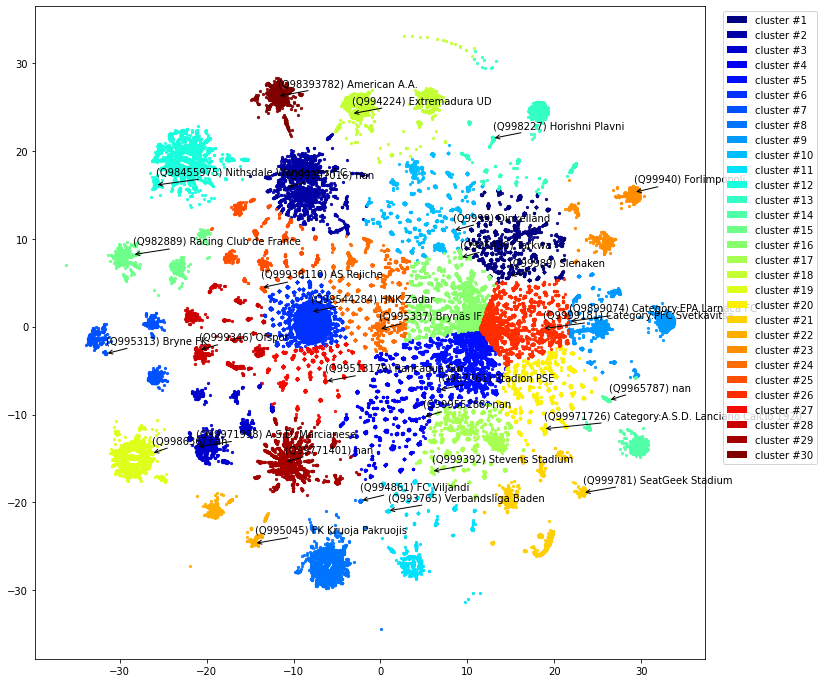

CPU times: user 11h 16min 47s, sys: 2h 38min 39s, total: 13h 55min 26s
Wall time: 3h 45min 48s


In [45]:
%%time
import numpy as np
import warnings   # silence numpy warnings
warnings.filterwarnings('ignore')
from ampligraph.datasets import load_from_csv
from ampligraph.latent_features import save_model, restore_model
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

variant = 'ComplEx-sports-football-club-team'
data = 'wd-triples-P31-obj-set-sports-football-club-team-labeled.tsv'

# Load data
X = load_from_csv('', data, sep='\t', header=1)
entities = np.unique(np.concatenate([X[:, 0], X[:, 2]]))
relations = np.unique(X[:, 1])
print("Num. of entities:", len(entities))

# Training/test split
num_test = int(len(X) * 0.05)  # Test size affects time to complete
data = {}
data['train'], data['test'] = train_test_split_no_unseen(X, test_size=num_test, seed=0, allow_duplication=False)
print("Set sizes: Train:", len(data['train']), ", Test:", len(data['test']) )
# data['train'], data['valid'] = train_test_split_no_unseen(data['train'], test_size=num_test)
# print("Set sizes: Train:", len(data['train']), ", Test:", len(data['test']), ", Validation:", len(data['valid']) )

#### Model hyperparameters
model = ComplEx(batches_count=20, # 200, 100, 50
                seed=0, 
                epochs=500,  # 200
                k=150, 
                eta=2,  # 5 - the number of negative, or false triples that must be generated at training runtime for each positive triple
                optimizer='adam', # adam, sdg
                optimizer_params={'lr':1e-3},
                loss='multiclass_nll', 
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                verbose=True)

# Checking that negative statements are in fact negative
positives_filter = X # data['train'] + data['test'] + data['valid']
filter1 = np.concatenate((data['train'], data['test'], data['valid'] )) if data.get('valid') else np.concatenate((data['train'], data['test'] ))

#### Train - no early stopping
model.fit(data['train'], early_stopping=False)

# Saving model
save_model(model, './model-'+ variant +'-2.pkl')

# Tensorboard model
create_tensorboard_visualizations(model, 'tensorboard_files-' + variant)

#### Evaluate
ranks = evaluate_performance(data['test'], 
                             model=model,
                             filter_unseen=True,  # could be False since train_test_split_unseen() used
                             entities_subset=random.sample(list(entities), 30), #entities[:100],
                             filter_triples=filter1, # Corruption strategy filter defined above 
                             #use_default_protocol=True, # default: False, If True, corrupt_side is ‘s,o’
                             corrupt_side='s+o', # Replaces use_default_protocol
                             verbose=True)

mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))

hits_50 = hits_at_n_score(ranks, n=50)
print("Hits@50: %.2f" % (hits_50))
hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))


# tSNE
TSNE_PERPLEXITY = 500  # 150 good
TSNE_LR = 100
TSNE_N_ITER = 1000
embed_2d = TSNE(n_components=2, #early_exaggeration=30, 
                init='pca',
                perplexity=TSNE_PERPLEXITY,  # default=30
                learning_rate=TSNE_LR,  # default=200.0
                n_iter=TSNE_N_ITER,  # default=1000
                n_jobs=4,
                verbose=True
                ).fit_transform(embeddings)

# Cluster embeddings (on the original space)
num_clusters = 30
clustering_model = KMeans(n_clusters=num_clusters, n_init=100, max_iter=500, random_state=0) #, verbose=True)
clustering_model.fit(embed_2d)

cluster_assignment = clustering_model.labels_
unique = list(set(cluster_assignment))
colors = [plt.cm.jet(i/float(len(unique)-1)) for i in range(num_clusters)]

print('starting processing')
xy_bycluster = {}
for cl in range(num_clusters):
    xy_bycluster[cl] = []
for cl in xy_bycluster:
    for ind in range(len(embed_2d)):
        if cluster_assignment[ind] == cl:
            xy_bycluster[cl].append((embed_2d[ind][0], embed_2d[ind][1]) )
id_labels_bycluster = {}
for cl in range(num_clusters):
    id_labels_bycluster[cl] = []
for cl in id_labels_bycluster:
    for ind in range(len(embed_2d)):
        if cluster_assignment[ind] == cl:
            id_labels_bycluster[cl].append( entities[ind] )

print('starting plot')
plt.figure(figsize=(12, 12))
for cl in xy_bycluster:
    print(cl)
    for indx, xy in enumerate(xy_bycluster[cl]):
        if indx % 1000 == 0:
            print("- indx:", indx)
        x, y = xy[0], xy[1]
        label = str(cluster_assignment[cl])
        id_label = id_labels_bycluster[cl][indx]
        plt.scatter(x, y, color=colors[cl], s=5, alpha=0.9)
        #plt.scatter(x, y, label=label, color=colors[cl], s=15, alpha=0.9)
        # annotate nodes - every Nth nodes
        # if indx % ((len(xy_bycluster[cl]) - 1) / 2) == 0:
        #     ax2.annotate(id_label, (x,y),
        #         textcoords="offset points", xytext=(0,10), arrowprops={'arrowstyle':'->'})
    # annotate last point in cluster iteration
    plt.annotate(id_label, (x,y),
               textcoords="offset points", xytext=(0,10), arrowprops={'arrowstyle':'->'})
# legend
c = [mpatches.Circle((1.5, 1.5), radius=5, facecolor=colors[ind], edgecolor="none") 
        for ind, x in enumerate(colors)]
labels = ["cluster #" + str(ind+1) for ind, x in enumerate(colors)]
plt.legend(handles=c, labels=labels, bbox_to_anchor=(1.175, 1), loc='upper right')

plt.show()
# plt.plot(embed_2d[:, 0], embed_2d[:, 1], 'k.', markersize=2)

Num. of entities: 66603
[t-SNE] Computing 751 nearest neighbors...
[t-SNE] Indexed 66603 samples in 2.456s...
[t-SNE] Computed neighbors for 66603 samples in 783.700s...
[t-SNE] Computed conditional probabilities for sample 1000 / 66603
[t-SNE] Computed conditional probabilities for sample 2000 / 66603
[t-SNE] Computed conditional probabilities for sample 3000 / 66603
[t-SNE] Computed conditional probabilities for sample 4000 / 66603
[t-SNE] Computed conditional probabilities for sample 5000 / 66603
[t-SNE] Computed conditional probabilities for sample 6000 / 66603
[t-SNE] Computed conditional probabilities for sample 7000 / 66603
[t-SNE] Computed conditional probabilities for sample 8000 / 66603
[t-SNE] Computed conditional probabilities for sample 9000 / 66603
[t-SNE] Computed conditional probabilities for sample 10000 / 66603
[t-SNE] Computed conditional probabilities for sample 11000 / 66603
[t-SNE] Computed conditional probabilities for sample 12000 / 66603
[t-SNE] Computed condit

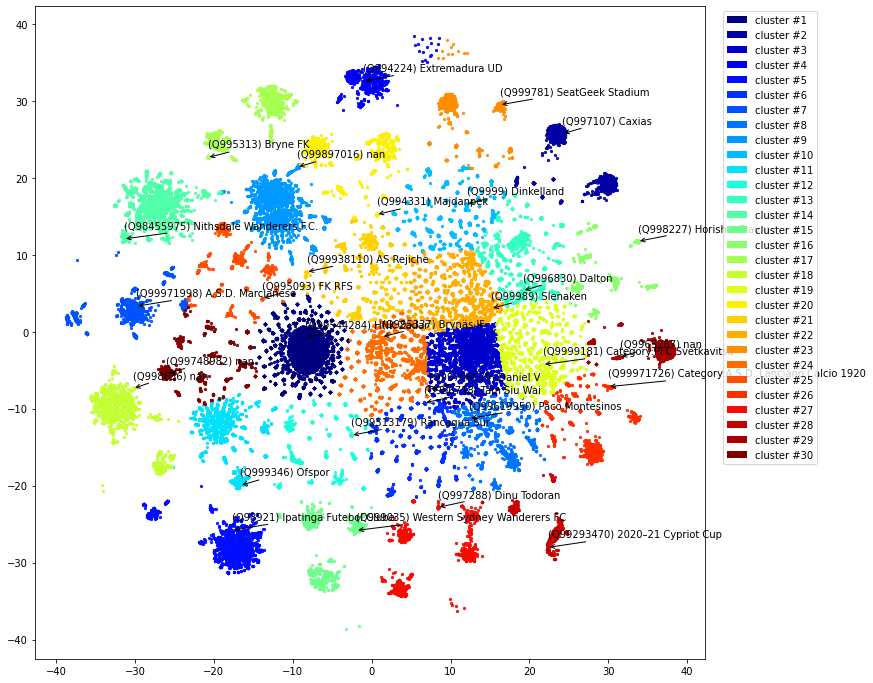

CPU times: user 5h 21min 26s, sys: 1h 6min 39s, total: 6h 28min 6s
Wall time: 2h 27min 45s


In [20]:
%%time
import numpy as np
import warnings   # silence numpy warnings
warnings.filterwarnings('ignore')
from ampligraph.datasets import load_from_csv
from ampligraph.latent_features import save_model, restore_model
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

variant = 'ComplEx-sports-football-club-team'
data = 'wd-triples-P31-obj-set-sports-football-club-team-labeled.tsv'

# Load data
X = load_from_csv('', data, sep='\t', header=1)
entities = np.unique(np.concatenate([X[:, 0], X[:, 2]]))
relations = np.unique(X[:, 1])
print("Num. of entities:", len(entities))

# Load model
model = restore_model('model-ComplEx-sports-football-club-team.pkl')
embeddings = model.get_embeddings(entities)

# tSNE
TSNE_PERPLEXITY = 250  # 150 good
TSNE_LR = 100
TSNE_N_ITER = 1000
embed_2d = TSNE(n_components=2, #early_exaggeration=30, 
                init='pca',
                perplexity=TSNE_PERPLEXITY,  # default=30
                learning_rate=TSNE_LR,  # default=200.0
                n_iter=TSNE_N_ITER,  # default=1000
                n_jobs=4,
                verbose=True
                ).fit_transform(embeddings)

# Cluster embeddings (on the original space)
num_clusters = 30
clustering_model = KMeans(n_clusters=num_clusters, n_init=100, max_iter=500, random_state=0) #, verbose=True)
clustering_model.fit(embed_2d)

cluster_assignment = clustering_model.labels_
unique = list(set(cluster_assignment))
colors = [plt.cm.jet(i/float(len(unique)-1)) for i in range(num_clusters)]

print('starting processing')
xy_bycluster = {}
for cl in range(num_clusters):
    xy_bycluster[cl] = []
for cl in xy_bycluster:
    for ind in range(len(embed_2d)):
        if cluster_assignment[ind] == cl:
            xy_bycluster[cl].append((embed_2d[ind][0], embed_2d[ind][1]) )
id_labels_bycluster = {}
for cl in range(num_clusters):
    id_labels_bycluster[cl] = []
for cl in id_labels_bycluster:
    for ind in range(len(embed_2d)):
        if cluster_assignment[ind] == cl:
            id_labels_bycluster[cl].append( entities[ind] )

print('starting plot')
plt.figure(figsize=(12, 12))
for cl in xy_bycluster:
    print(cl)
    for indx, xy in enumerate(xy_bycluster[cl]):
        if indx % 1000 == 0:
            print("- indx:", indx)
        x, y = xy[0], xy[1]
        label = str(cluster_assignment[cl])
        id_label = id_labels_bycluster[cl][indx]
        plt.scatter(x, y, color=colors[cl], s=5, alpha=0.9)
        #plt.scatter(x, y, label=label, color=colors[cl], s=15, alpha=0.9)
        # annotate nodes - every Nth nodes
        # if indx % ((len(xy_bycluster[cl]) - 1) / 2) == 0:
        #     ax2.annotate(id_label, (x,y),
        #         textcoords="offset points", xytext=(0,10), arrowprops={'arrowstyle':'->'})
    # annotate last point in cluster iteration
    plt.annotate(id_label, (x,y),
               textcoords="offset points", xytext=(0,10), arrowprops={'arrowstyle':'->'})
# legend
c = [mpatches.Circle((1.5, 1.5), radius=5, facecolor=colors[ind], edgecolor="none") 
        for ind, x in enumerate(colors)]
labels = ["cluster #" + str(ind+1) for ind, x in enumerate(colors)]
plt.legend(handles=c, labels=labels, bbox_to_anchor=(1.175, 1), loc='upper right')
    
plt.show()
# plt.plot(embed_2d[:, 0], embed_2d[:, 1], 'k.', markersize=2)

In [32]:
embed_2d
entities

array(['(Q100) Boston', '(Q1000) Gabon', '(Q1000052) Coruche', ...,
       '(Q9999) Dinkelland', '(Q9999050) Category:PFC Ludogorets Razgrad',
       '(Q9999181) Category:PFC Svetkavitsa'], dtype=object)

In [42]:
import pickle
from matplotlib.colors import to_hex

# Export pickled data for Heroku app
pickle_name = "source1-tSNE-" + variant + "-Perplexity_" + str(TSNE_PERPLEXITY) \
                    +"-LearningRate_"+ str(TSNE_LR) \
                    +"-Iterations_"+ str(TSNE_N_ITER) \
                    +"-KmeansClusters_"+ str(num_clusters) \
                    + ".pickle"
with open('pickles/' + pickle_name, 'wb') as f:
    pickle.dump(dict(x=embed_2d[:,0], y=embed_2d[:,1], cluster=cluster_assignment,
                     colors=[to_hex(colors[c][:3]) for c in cluster_assignment],
                     entity_label=entities), f)

Num. of entities: 191768
[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 100000 samples in 3.989s...
[t-SNE] Computed neighbors for 100000 samples in 5364.340s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] 

- indx: 1000
- indx: 2000
- indx: 3000
19
- indx: 0
- indx: 1000
- indx: 2000
20
- indx: 0
- indx: 1000
21
- indx: 0
- indx: 1000
- indx: 2000
- indx: 3000
22
- indx: 0
- indx: 1000
- indx: 2000
23
- indx: 0
- indx: 1000
- indx: 2000
- indx: 3000
- indx: 4000
- indx: 5000
24
- indx: 0
- indx: 1000
- indx: 2000
- indx: 3000
- indx: 4000
25
- indx: 0
- indx: 1000
26
- indx: 0
- indx: 1000
- indx: 2000
- indx: 3000
27
- indx: 0
- indx: 1000
- indx: 2000
- indx: 3000
28
- indx: 0
- indx: 1000
- indx: 2000
29
- indx: 0
- indx: 1000
- indx: 2000


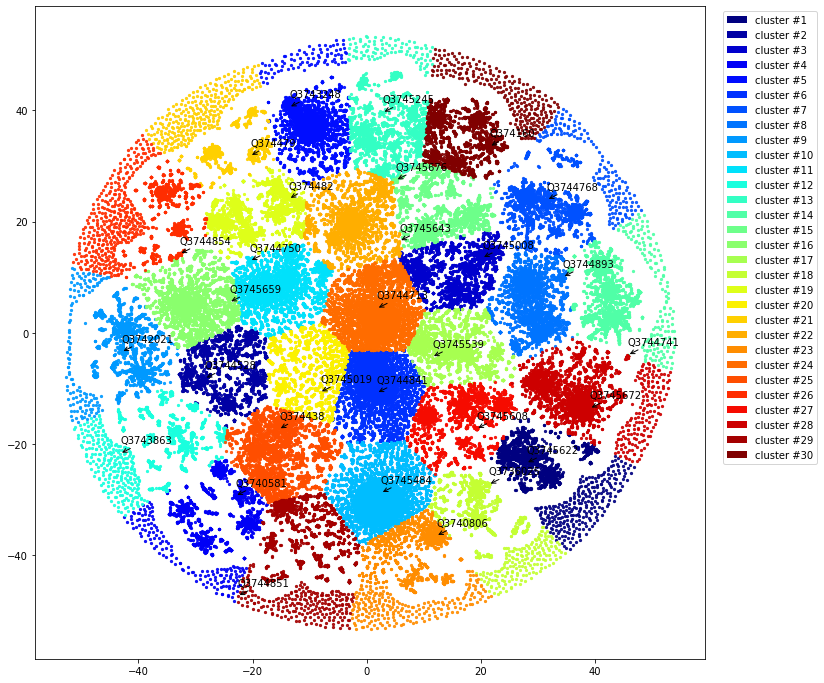

In [9]:
import numpy as np
import warnings   # silence numpy warnings
warnings.filterwarnings('ignore')
from ampligraph.datasets import load_from_csv
from ampligraph.latent_features import save_model, restore_model
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

variant = 'ComplEx-music-album-single'
# data = 'wd-triples-P31-obj-set-music-album-single-10K.tsv'
# data = 'wd-triples-P31-obj-set-music-album-single-50K.tsv'
# data = 'wd-triples-P31-obj-set-music-album-single-100K.tsv'
data = 'wd-triples-P31-obj-set-music-album-single-500K.tsv'

# Load data
X = load_from_csv('', data, sep='\t')
entities = np.unique(np.concatenate([X[:, 0], X[:, 2]]))
relations = np.unique(X[:, 1])
print("Num. of entities:", len(entities))

# Load model
model = restore_model('model-ComplEx-music-album-single.pkl')
embeddings = model.get_embeddings(entities)[:100000]

# Project embeddings into 2D space via PCA
# embed_2d = PCA(n_components=2).fit_transform(embeddings)

# tSNE
TSNE_PERPLEXITY = 15
TSNE_LR = 200
TSNE_N_ITER = 1000
embed_2d = TSNE(n_components=2, #early_exaggeration=30, init='pca',
                    perplexity=TSNE_PERPLEXITY,  # default=30
                    learning_rate=TSNE_LR,  # default=200.0
                    n_iter=TSNE_N_ITER,  # default=1000
                    n_jobs=4,
                    verbose=True
                    ).fit_transform(embeddings)

# Cluster embeddings (on the original space)
num_clusters = 30
clustering_model = KMeans(n_clusters=num_clusters, n_init=100, max_iter=500, random_state=0) #, verbose=True)
clustering_model.fit(embed_2d)

cluster_assignment = clustering_model.labels_
unique = list(set(cluster_assignment))
colors = [plt.cm.jet(i/float(len(unique)-1)) for i in range(num_clusters)]

print('starting processing')
xy_bycluster = {}
for cl in range(num_clusters):
    xy_bycluster[cl] = []
for cl in xy_bycluster:
    for ind in range(len(embed_2d)):
        if cluster_assignment[ind] == cl:
            xy_bycluster[cl].append((embed_2d[ind][0], embed_2d[ind][1]) )
id_labels_bycluster = {}
for cl in range(num_clusters):
    id_labels_bycluster[cl] = []
for cl in id_labels_bycluster:
    for ind in range(len(embed_2d)):
        if cluster_assignment[ind] == cl:
            id_labels_bycluster[cl].append( entities[ind] )

print('starting plot')
plt.figure(figsize=(12, 12))
# fig = plt.figure(figsize=(12, 12))  #.subplots(1, 2)
# fig.set_size_inches(25, 4)
for cl in xy_bycluster:
    print(cl)
    for indx, xy in enumerate(xy_bycluster[cl]):
        if indx % 1000 == 0:
            print("- indx:", indx)
        x, y = xy[0], xy[1]
        label = str(cluster_assignment[cl])
        id_label = id_labels_bycluster[cl][indx]
        plt.scatter(x, y, color=colors[cl], s=5, alpha=0.9)
        #plt.scatter(x, y, label=label, color=colors[cl], s=15, alpha=0.9)
        # annotate nodes - every Nth nodes
        # if indx % ((len(xy_bycluster[cl]) - 1) / 2) == 0:
        #     ax2.annotate(id_label, (x,y),
        #         textcoords="offset points", xytext=(0,10), arrowprops={'arrowstyle':'->'})
    # annotate last point in cluster iteration
    plt.annotate(id_label, (x,y),
               textcoords="offset points", xytext=(0,10), arrowprops={'arrowstyle':'->'})
# legend
c = [mpatches.Circle((1.5, 1.5), radius=5, facecolor=colors[ind], edgecolor="none") 
        for ind, x in enumerate(colors)]
labels = ["cluster #" + str(ind+1) for ind, x in enumerate(colors)]
plt.legend(handles=c, labels=labels, bbox_to_anchor=(1.175, 1), loc='upper right')
    
plt.show()

# plt.plot(embed_2d[:, 0], embed_2d[:, 1], 'k.', markersize=2)

Num. of entities: 191768
[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 191768 samples in 9.023s...
[t-SNE] Computed neighbors for 191768 samples in 5218.865s...
[t-SNE] Computed conditional probabilities for sample 1000 / 191768
[t-SNE] Computed conditional probabilities for sample 2000 / 191768
[t-SNE] Computed conditional probabilities for sample 3000 / 191768
[t-SNE] Computed conditional probabilities for sample 4000 / 191768
[t-SNE] Computed conditional probabilities for sample 5000 / 191768
[t-SNE] Computed conditional probabilities for sample 6000 / 191768
[t-SNE] Computed conditional probabilities for sample 7000 / 191768
[t-SNE] Computed conditional probabilities for sample 8000 / 191768
[t-SNE] Computed conditional probabilities for sample 9000 / 191768
[t-SNE] Computed conditional probabilities for sample 10000 / 191768
[t-SNE] Computed conditional probabilities for sample 11000 / 191768
[t-SNE] Computed conditional probabilities for sample 12000 / 191768
[t-SNE] C

[t-SNE] Computed conditional probabilities for sample 143000 / 191768
[t-SNE] Computed conditional probabilities for sample 144000 / 191768
[t-SNE] Computed conditional probabilities for sample 145000 / 191768
[t-SNE] Computed conditional probabilities for sample 146000 / 191768
[t-SNE] Computed conditional probabilities for sample 147000 / 191768
[t-SNE] Computed conditional probabilities for sample 148000 / 191768
[t-SNE] Computed conditional probabilities for sample 149000 / 191768
[t-SNE] Computed conditional probabilities for sample 150000 / 191768
[t-SNE] Computed conditional probabilities for sample 151000 / 191768
[t-SNE] Computed conditional probabilities for sample 152000 / 191768
[t-SNE] Computed conditional probabilities for sample 153000 / 191768
[t-SNE] Computed conditional probabilities for sample 154000 / 191768
[t-SNE] Computed conditional probabilities for sample 155000 / 191768
[t-SNE] Computed conditional probabilities for sample 156000 / 191768
[t-SNE] Computed con

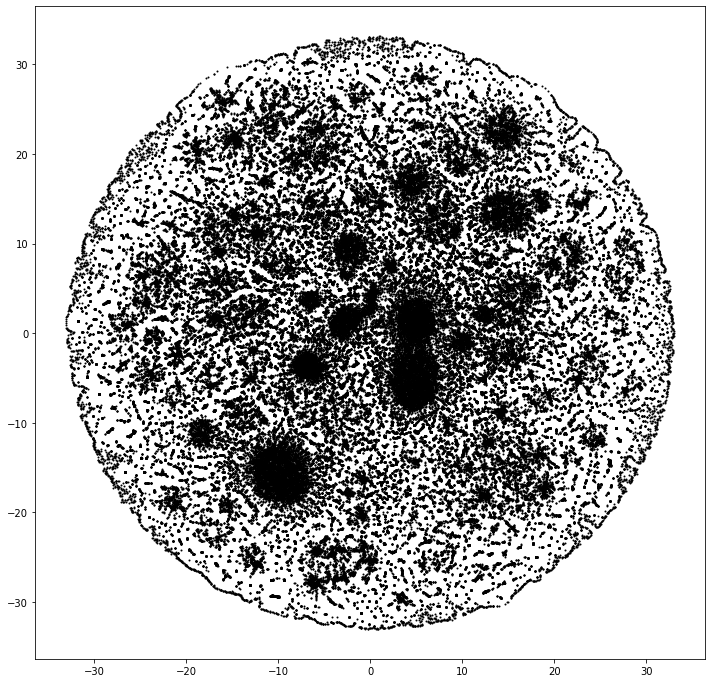

CPU times: user 13h 36s, sys: 44.1 s, total: 13h 1min 21s
Wall time: 1h 38min 27s


In [18]:
%%time
import numpy as np
import warnings   # silence numpy warnings
warnings.filterwarnings('ignore')
from ampligraph.datasets import load_from_csv
from ampligraph.latent_features import save_model, restore_model
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

variant = 'ComplEx-music-album-single'
# data = 'wd-triples-P31-obj-set-music-album-single-10K.tsv'
# data = 'wd-triples-P31-obj-set-music-album-single-50K.tsv'
# data = 'wd-triples-P31-obj-set-music-album-single-100K.tsv'
data = 'wd-triples-P31-obj-set-music-album-single-500K.tsv'

# Load data
X = load_from_csv('', data, sep='\t')
entities = np.unique(np.concatenate([X[:, 0], X[:, 2]]))
relations = np.unique(X[:, 1])
print("Num. of entities:", len(entities))

# Load model
model = restore_model('model-ComplEx-music-album-single.pkl')
embeddings = model.get_embeddings(entities) #[:100000]

# Project embeddings into 2D space via PCA
# embed_2d = PCA(n_components=2).fit_transform(embeddings)

# tSNE
TSNE_PERPLEXITY = 2
TSNE_LR = 100
TSNE_N_ITER = 1000
embed_2d = TSNE(n_components=2, #early_exaggeration=30, init='pca',
                    perplexity=TSNE_PERPLEXITY,  # default=30
                    learning_rate=TSNE_LR,  # default=200.0
                    n_iter=TSNE_N_ITER,  # default=1000
                    n_jobs=4,
                    verbose=True
                    ).fit_transform(embeddings)
'''

'''

plt.figure(figsize=(12, 12))
plt.plot(embed_2d[:, 0], embed_2d[:, 1], 'k.', markersize=2)
plt.show()

Num. of entities: 191768
[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 100000 samples in 4.053s...
[t-SNE] Computed neighbors for 100000 samples in 1410.404s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE]

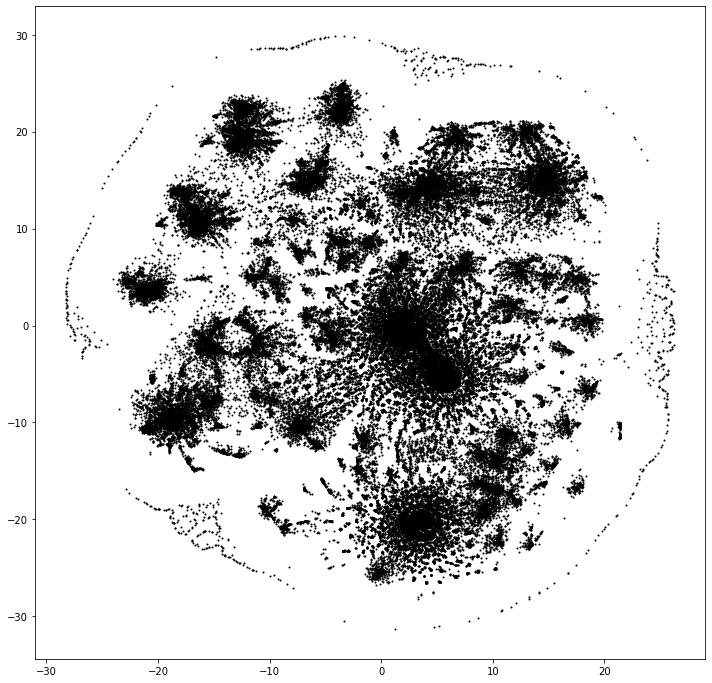

In [8]:
%%time
import numpy as np
import warnings   # silence numpy warnings
warnings.filterwarnings('ignore')
from ampligraph.datasets import load_from_csv
from ampligraph.latent_features import save_model, restore_model
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

variant = 'ComplEx-music-album-single'
# data = 'wd-triples-P31-obj-set-music-album-single-10K.tsv'
# data = 'wd-triples-P31-obj-set-music-album-single-50K.tsv'
# data = 'wd-triples-P31-obj-set-music-album-single-100K.tsv'
data = 'wd-triples-P31-obj-set-music-album-single-500K.tsv'

# Load data
X = load_from_csv('', data, sep='\t')
entities = np.unique(np.concatenate([X[:, 0], X[:, 2]]))
relations = np.unique(X[:, 1])
print("Num. of entities:", len(entities))

# Load model
model = restore_model('model-ComplEx-music-album-single.pkl')
embeddings = model.get_embeddings(entities)[:100000]

# Project embeddings into 2D space via PCA
# embed_2d = PCA(n_components=2).fit_transform(embeddings)

# tSNE
TSNE_PERPLEXITY = 200
TSNE_LR = 100
TSNE_N_ITER = 1000
embed_2d = TSNE(n_components=2, #early_exaggeration=30, init='pca',
                    perplexity=TSNE_PERPLEXITY,  # default=30
                    learning_rate=TSNE_LR,  # default=200.0
                    n_iter=TSNE_N_ITER,  # default=1000
                    n_jobs=4,
                    verbose=True
                    ).fit_transform(embeddings)
'''

'''

plt.figure(figsize=(12, 12))
plt.plot(embed_2d[:, 0], embed_2d[:, 1], 'k.', markersize=2)
plt.show()

In [ ]:
"""wd-triples-P31-obj-set-music-album-single-100K.tsv
Set sizes: Train:  79997 , Test:  9999 , Validation:  9999

Average Loss:   0.087906: 100%|██████████| 20/20 [02:18<00:00,  6.92s/epoch]

WARNING - You are attempting to use 52976 distinct entities to generate synthetic negatives in the evaluation 
    protocol. This may be unnecessary and will lead to a 'harder' task. Besides, it will lead to a much slower 
    evaluation procedure. We recommended to set the 'corruption_entities' argument to a reasonably sized set 
    of entities. The size of corruption_entities depends on your domain-specific task.

100%|██████████| 9999/9999 [33:33<00:00,  4.97it/s]

MRR: 0.02
Hits@50: 0.09
Hits@10: 0.04
Hits@3: 0.02
Hits@1: 0.01


# 20 epochs, early_stopping=False works OK
wd-triples-P31-obj-set-music-album-single-50K.tsv
Set sizes: Train:  30008 , Test:  9999 , Validation:  9989

Average Loss:   0.086849: 100%|██████████| 20/20 [01:02<00:00,  3.10s/epoch]
100%|██████████| 9999/9999 [15:51<00:00, 10.51it/s]

MRR: 0.01
Hits@50: 0.07
Hits@10: 0.03
Hits@3: 0.01
Hits@1: 0.01

# 20 epochs, early_stopping=True
wd-triples-P31-obj-set-music-album-single-50K.tsv
Set sizes: Train:  30008 , Test:  9999 , Validation:  9989

Average Loss:   0.086849 — Best validation (hits10): 1.000000: 100%|██████████| 20/20 [02:31<00:00,  7.60s/epoch]
100%|██████████| 9999/9999 [15:34<00:00, 10.70it/s]

MRR: 0.01
Hits@50: 0.07
Hits@10: 0.03
Hits@3: 0.01
Hits@1: 0.01
"""

In [35]:
data

{'train': array([['Q2406', 'P175', 'Q47122'],
        ['Q2406', 'P156', 'Q959411'],
        ['Q2406', 'P361', 'Q2723036'],
        ...,
        ['Q3950780', 'P175', 'Q3843927'],
        ['Q3950780', 'P264', 'Q3976712'],
        ['Q3950780', 'P162', 'Q3742546']], dtype=object),
 'test': array([['Q2406', 'P264', 'Q7894020'],
        ['Q2406', 'P31', 'Q134556'],
        ['Q2406', 'P155', 'Q3925992'],
        ...,
        ['Q3950356', 'P175', 'Q229513'],
        ['Q3950356', 'P407', 'Q1860'],
        ['Q3950780', 'P31', 'Q134556']], dtype=object),
 'valid': array([['Q2406', 'P264', 'Q38903'],
        ['Q2406', 'P136', 'Q37073'],
        ['Q16416', 'P31', 'Q482994'],
        ...,
        ['Q3950591', 'P175', 'Q507659'],
        ['Q3950609', 'P31', 'Q482994'],
        ['Q3950609', 'P136', 'Q11399']], dtype=object)}